# Feature Selection

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np
from datetime import datetime

# Plotting graphs
import matplotlib.pyplot as plt

# Machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit

from ta import add_all_ta_features #pip install --upgrade ta https://github.com/bukosabino/ta https://medium.datadriveninvestor.com/predicting-the-stock-market-with-python-bba3cf4c56ef
from fastai.tabular.all import add_datepart #pip install fastai https://docs.fast.ai/tabular.core.html https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/

### (Part0) Data Preparation & Helper Function

We will use Apple Stock Price data from 2022-01-01 to 2021-4-28 (4month). We will include all the technical features we produced to perform feature selection. 

In [2]:
def prepare_dataset(path = 'data/AAPL_data.csv', s_path = 'data/AAPL_byday_RoBERTa.csv', start_date = '2022-01-01', sentiment = False):
    '''
    Load dataset and generate technical features and limit time periods. 

    path(str) : path to the price data file.
    s_path(str) : path to the stocktwits data file. 
    select_feature(boolean) : if true keep selected features
    start_date(str) : start date of interested time period. 
    '''
    df = pd.read_csv(path)
    df.dropna()

    df["Date"] = pd.to_datetime(df.Date, format="%Y-%m-%d")
    df.index = df['Date']
    df = df.sort_index(ascending=True, axis=0)
    add_datepart(df, 'Date', drop=False)
    df.drop('Elapsed', axis=1, inplace=True)

    df = add_all_ta_features(
        df, high="High", low="Low", open="Open", close="Close", volume="Volume")
    
    df = df[df['Date'] >= start_date]

    y = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

    if sentiment:
        df.index = np.array(range(len(df)))
        df_sentiment = pd.read_csv(s_path)
        if s_path == 'data/AAPL_byday_RoBERTa.csv':
        # Drop the first empty column for AAPL
            df_sentiment = df_sentiment.iloc[: , 1:]
        df_sentiment.date = df_sentiment.date.apply(convert)
        df_sentiment.rename(columns={'date':'Date'}, inplace=True)
        df = df.merge(df_sentiment, how='inner', on='Date').fillna(0)

    X = df.drop(['Close', 'trend_psar_down', 'trend_psar_up', 'Date', 'Adj Close'], axis=1)
    cols = X.columns
    
    X = np.array(X)
    X = X.astype(np.float32)

    # Split training and validation data
    split = int(0.8 * len(X))
    X_train = X[:split]
    y_train = y[:split]

    return X_train, y_train, cols

In [3]:
def convert(date_string):
    year, month, day = [int(i) for i in date_string.split('-')]
    return datetime(year=year, month=month, day=day)

In [4]:
def random_forest(X_train, X_test, y_train, y_test):
    '''
    Run random forest and return model and accuracy score. 
    '''
    model = RandomForestClassifier(random_state=42, n_estimators=100)
    model.fit(X_train, y_train)
    return model, model.score(X_test, y_test), model.feature_importances_

In [5]:
def adaboost(X_train, X_test, y_train, y_test):
    '''
    Run adaboost and return model and accuracy score. 
    '''   
    model = AdaBoostClassifier(random_state=42, n_estimators=100)
    model.fit(X_train, y_train)
    return model, model.score(X_test, y_test), model.feature_importances_

In [6]:
def gradient_boost(X_train, X_test, y_train, y_test):
    '''
    Run gradient boosting and return model and accuracy score. 
    '''       
    model = GradientBoostingClassifier(random_state=42, n_estimators=100)
    model.fit(X_train, y_train)
    return model, model.score(X_test, y_test), model.feature_importances_

In [7]:
def sklearn_cross_validation(df_X, df_y, split, verbose, plot = False):
    '''
    Do cross validation based on ScikitLearn's Time Series Split
    '''
    tscv = TimeSeriesSplit(n_splits=split)

    rf_results = []
    ada_results = []
    gradient_results = []
    rf_feature_imp = np.zeros(df_X.shape[1])
    ada_feature_imp = np.zeros(df_X.shape[1])
    gra_feature_imp = np.zeros(df_X.shape[1])

    for train_index, validation_index in tscv.split(df_X):
        # print("TRAIN:", train_index, "VALIDATION:", validation_index)
        X_train, X_validation = df_X[train_index], df_X[validation_index]
        y_train, y_validation = df_y[train_index], df_y[validation_index]

        t_scaler = MinMaxScaler()
        X_train = t_scaler.fit_transform(X_train)
        X_validation = t_scaler.transform(X_validation)

        if len(np.unique(y_train)) == 1:
            continue

        rf, rf_accuracy, rf_imp = random_forest(X_train, X_validation, y_train, y_validation)
        rf_results.append(rf_accuracy)
        rf_feature_imp = rf_feature_imp + rf_imp
        ada, ada_accuracy, ada_imp = adaboost(X_train, X_validation, y_train, y_validation)
        ada_results.append(ada_accuracy)
        ada_feature_imp = ada_feature_imp + ada_imp
        gra, gra_accuracy, gra_imp = gradient_boost(X_train, X_validation, y_train, y_validation)
        gradient_results.append(gra_accuracy)
        gra_feature_imp = gra_feature_imp + gra_imp

    rf_feature_imp = rf_feature_imp / split
    ada_feature_imp = ada_feature_imp / split
    gra_feature_imp = gra_feature_imp / split

    if verbose:
        print("Mean Accuracy of Random Forests", sum(rf_results)/len(rf_results))
        print("Mean Accuracy of Adaboost", sum(ada_results)/len(ada_results))
        print("Mean Accuracy of Gradient Boosting", sum(gradient_results)/len(gradient_results))
    
    if plot:
        return sum(rf_results)/len(rf_results), sum(ada_results)/len(ada_results), sum(gradient_results)/len(gradient_results)
    return rf_feature_imp, ada_feature_imp, gra_feature_imp

In [8]:
def feature_importance(importances, columns): 
    feature_names = [i for i in columns]
    forest_importances = pd.Series(importances, index=feature_names)
    forest_importances = forest_importances.sort_values(ascending=False)
    
    print('Top 20 Best Features : \n')
    print(forest_importances.head(20))
    fig, ax = plt.subplots(figsize=(30,20))
    forest_importances.plot.bar(ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    return forest_importances

## Apple

In [9]:
np.random.seed(1234)

In [10]:
# AAPL : Data with full set of technical features
X_train_AAPL, y_train_AAPL, columns_AAPL = prepare_dataset()

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


In [11]:
rf_AAPL, ada_AAPL, gra_AAPL = sklearn_cross_validation(X_train_AAPL, y_train_AAPL, 5, verbose=True, plot=False)

Mean Accuracy of Random Forests 0.6
Mean Accuracy of Adaboost 0.5
Mean Accuracy of Gradient Boosting 0.68


**Compare accuracies among different k-folds**

Mean Accuracy of Random Forests 0.3958333333333333
Mean Accuracy of Adaboost 0.4583333333333333
Mean Accuracy of Gradient Boosting 0.5
Mean Accuracy of Random Forests 0.6
Mean Accuracy of Adaboost 0.5
Mean Accuracy of Gradient Boosting 0.68
Mean Accuracy of Random Forests 0.52
Mean Accuracy of Adaboost 0.58
Mean Accuracy of Gradient Boosting 0.54


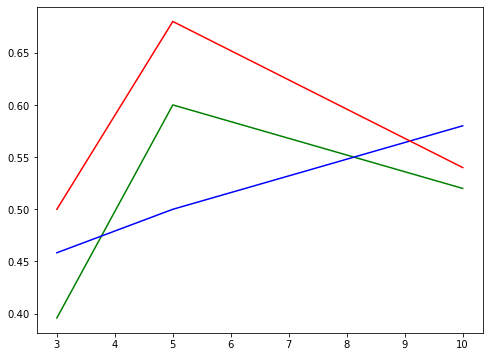

In [12]:
num_folds = [3,5,10] #commonly used k folds
acc_rf = []
acc_ada = []
acc_gb = []

for fold in num_folds:
    rf, ada, gb = sklearn_cross_validation(X_train_AAPL, y_train_AAPL, fold, verbose=True, plot=True)
    acc_rf.append(rf)
    acc_ada.append(ada)
    acc_gb.append(gb)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax.plot(num_folds, acc_rf, color = 'Green')
ax.plot(num_folds, acc_ada, color = 'Blue')
ax.plot(num_folds, acc_gb, color = 'Red')

**Feature Importance from Random Forest**

Top 20 Best Features : 

volume_nvi               0.034599
volume_vwap              0.028581
momentum_pvo             0.027086
volatility_bbl           0.022438
others_dlr               0.019547
momentum_ao              0.018927
volatility_atr           0.018801
trend_dpo                0.018651
momentum_tsi             0.018415
trend_mass_index         0.017972
momentum_stoch_rsi_k     0.017680
volume_mfi               0.017461
trend_kst_sig            0.017250
trend_sma_fast           0.017022
volatility_kch           0.015828
volume_sma_em            0.015606
volume_cmf               0.015520
volatility_kcl           0.015262
trend_ichimoku_a         0.015098
trend_vortex_ind_diff    0.015038
dtype: float64


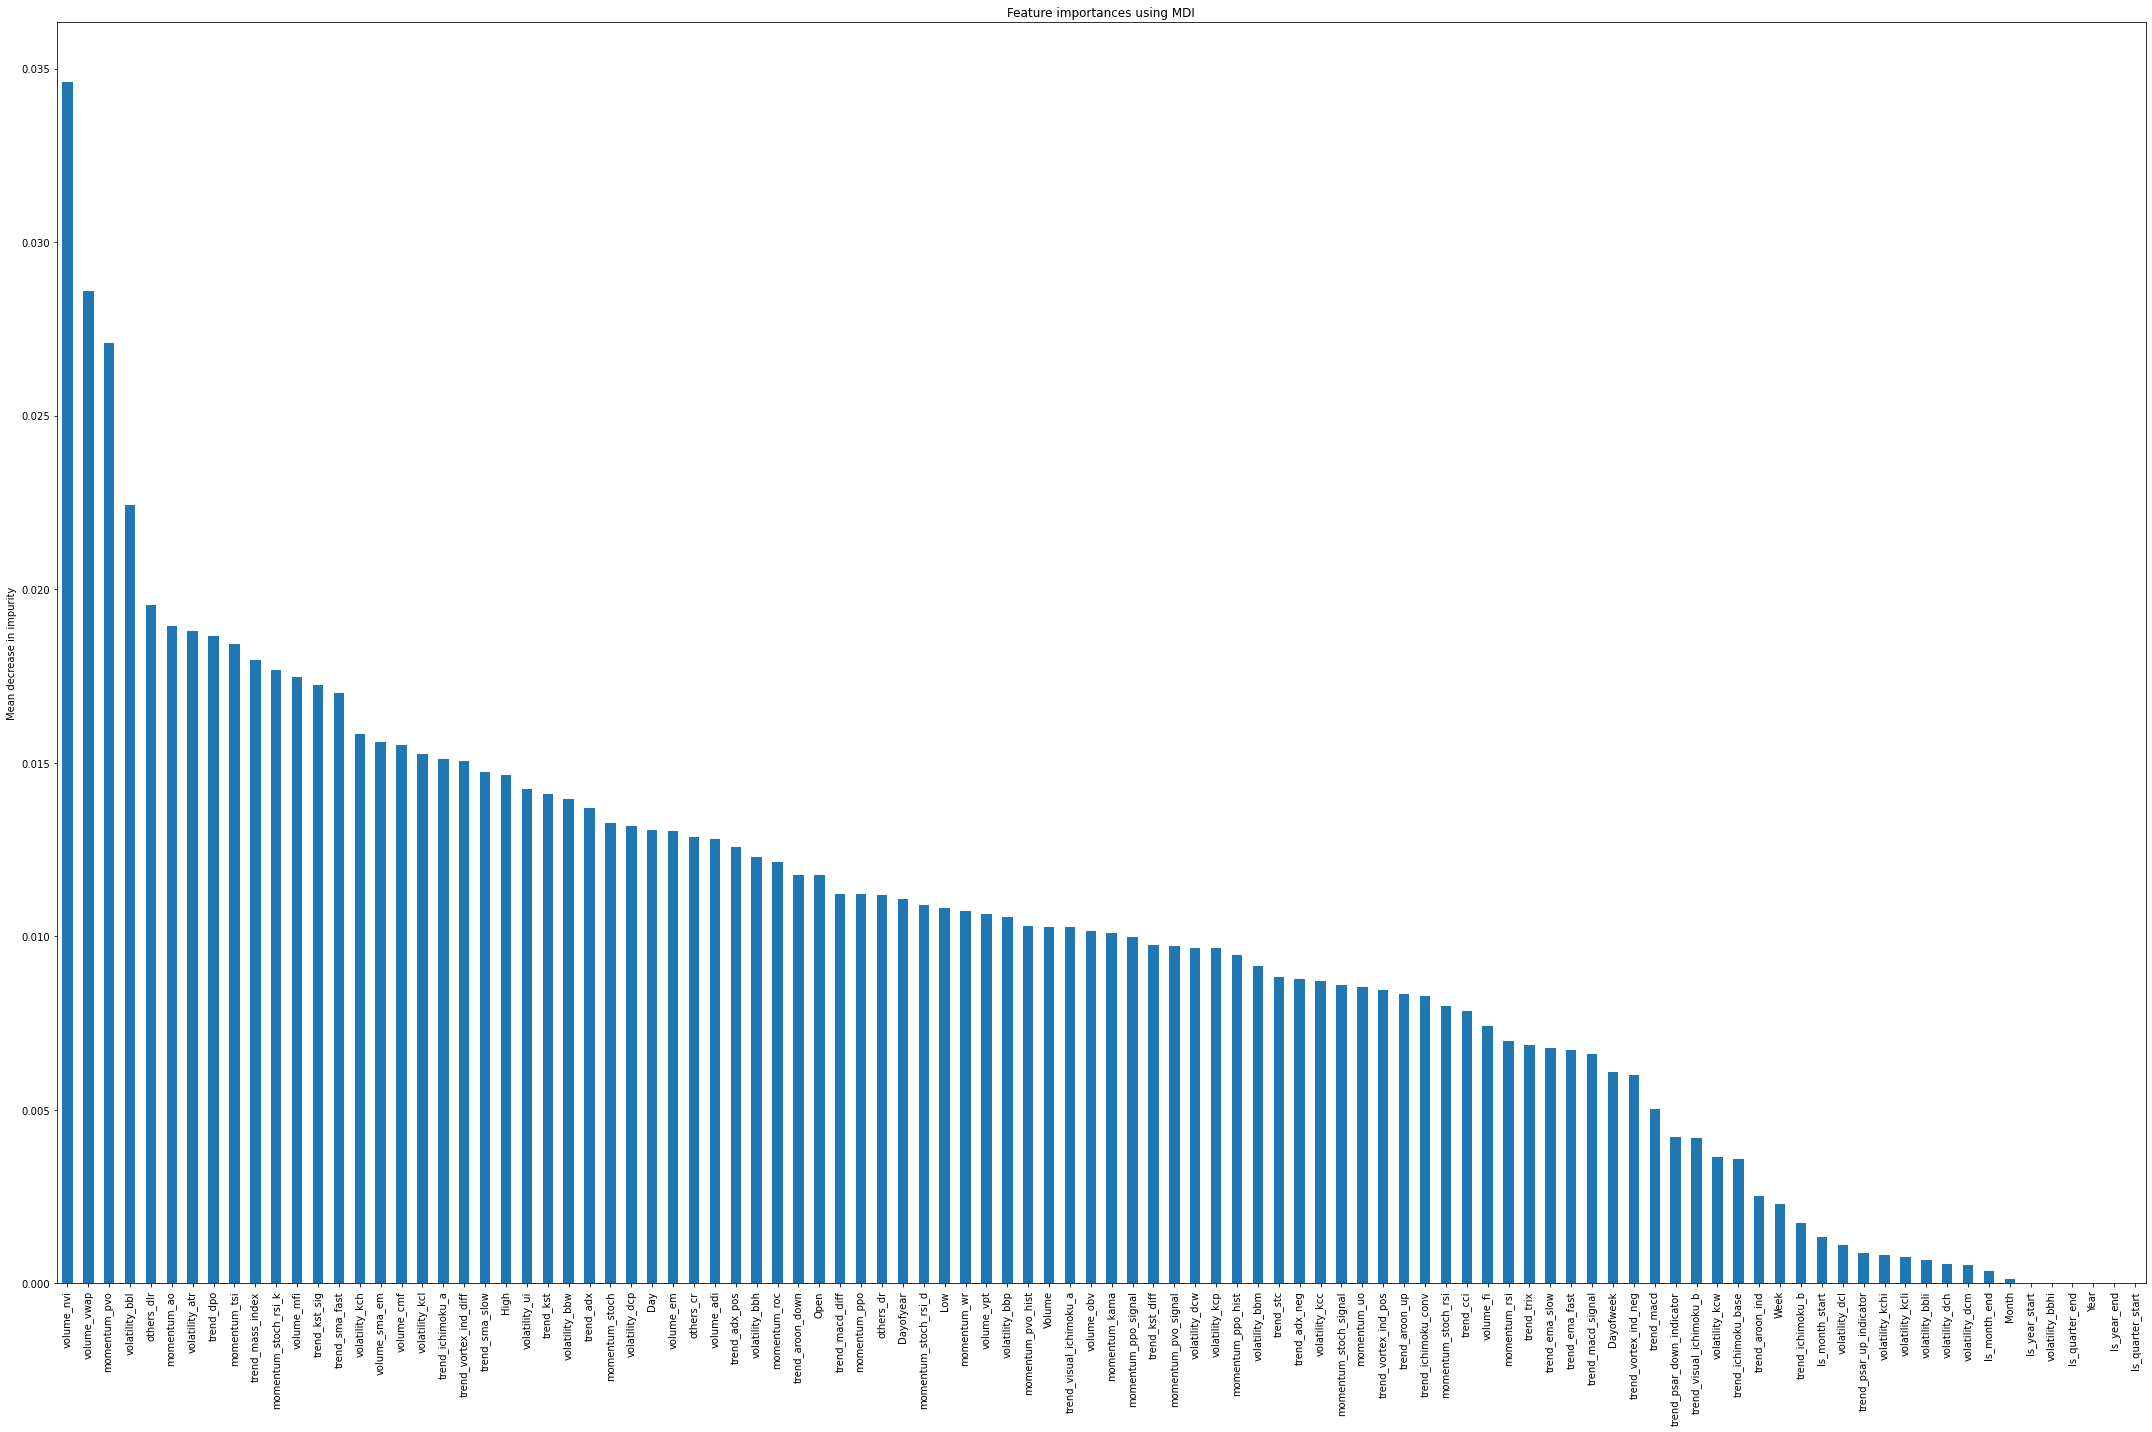

In [13]:
_ = feature_importance(rf_AAPL, columns_AAPL)

**Feature Importance from Adaboost**

Top 20 Best Features : 

momentum_pvo               0.142
trend_mass_index           0.126
momentum_pvo_hist          0.058
momentum_stoch_signal      0.050
volume_adi                 0.040
volume_nvi                 0.036
volatility_dcp             0.034
trend_dpo                  0.026
trend_sma_fast             0.024
volatility_bbw             0.022
volatility_kcl             0.020
trend_visual_ichimoku_a    0.020
volatility_bbl             0.020
trend_stc                  0.018
volatility_kcp             0.016
trend_vortex_ind_neg       0.014
volatility_bbp             0.012
volatility_bbh             0.012
Day                        0.012
momentum_wr                0.012
dtype: float64


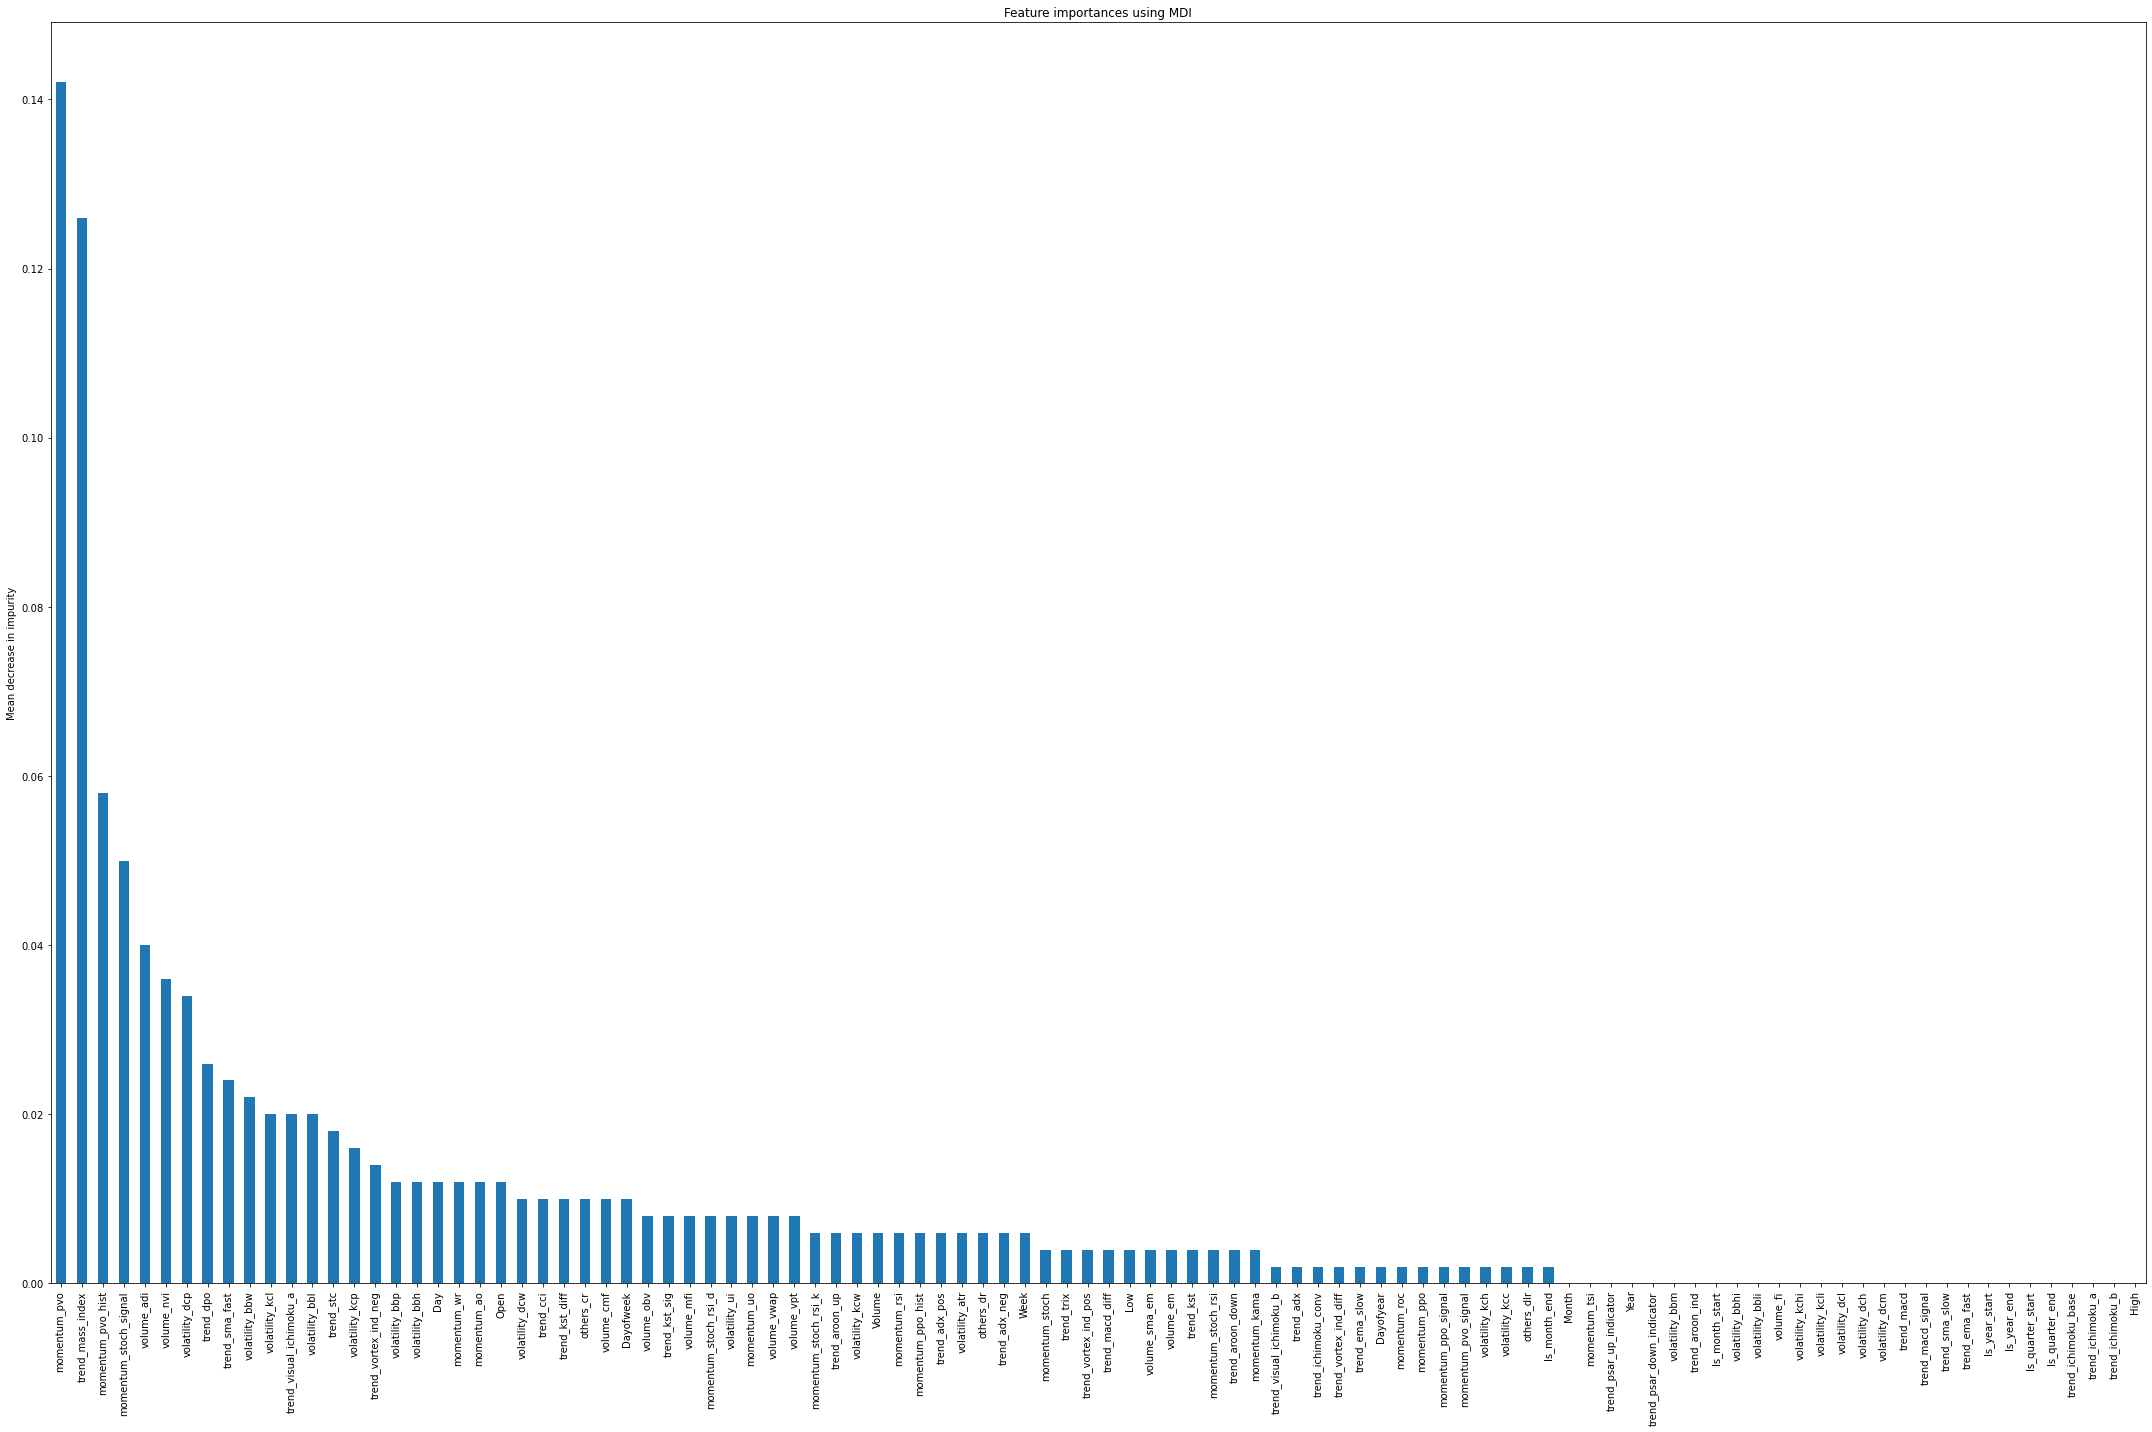

In [14]:
_ = feature_importance(ada_AAPL, columns_AAPL)

**Feature Importance from Gradient Boosting**

Top 20 Best Features : 

trend_vortex_ind_pos     0.094298
momentum_pvo             0.084528
trend_sma_fast           0.080493
volume_vwap              0.062812
volatility_ui            0.058859
trend_dpo                0.054135
trend_kst_sig            0.037640
trend_sma_slow           0.033735
trend_stc                0.033378
momentum_stoch_signal    0.030128
volume_nvi               0.028335
volume_cmf               0.026912
trend_mass_index         0.025750
momentum_ao              0.021440
trend_macd_diff          0.020428
momentum_kama            0.020127
trend_aroon_down         0.019549
volume_vpt               0.019390
volatility_atr           0.016085
Day                      0.016080
dtype: float64


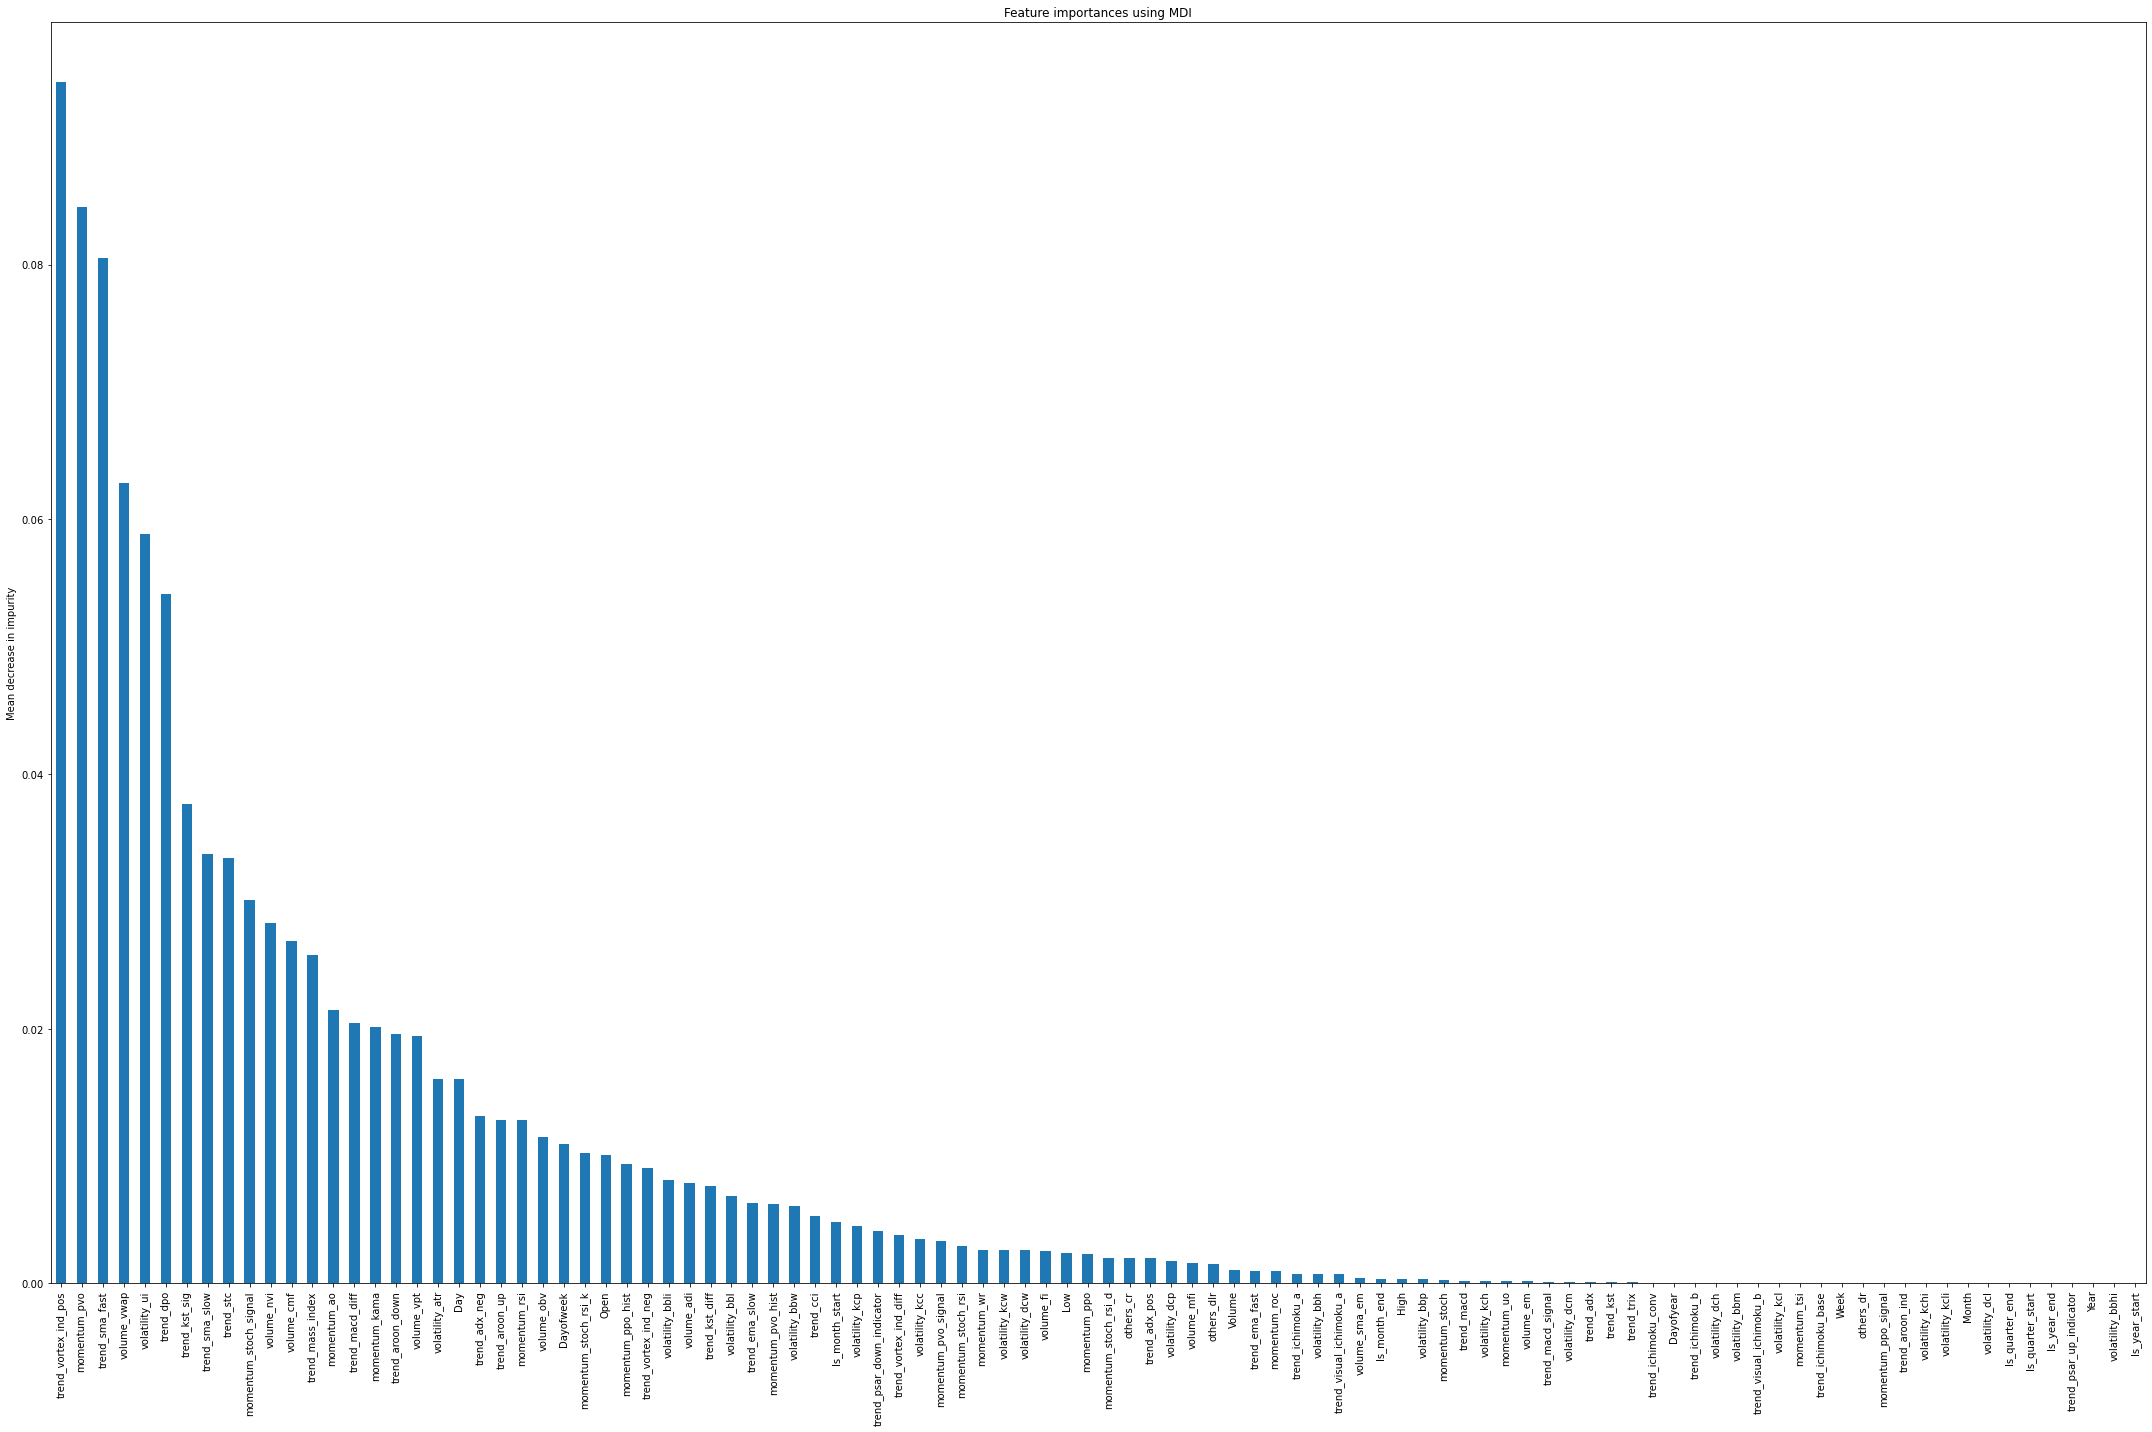

In [15]:
_ = feature_importance(gra_AAPL, columns_AAPL)

**Average of Three Models**

Top 20 Best Features : 

momentum_pvo             0.084538
trend_mass_index         0.056574
trend_sma_fast           0.040505
trend_vortex_ind_pos     0.035584
volume_vwap              0.033131
volume_nvi               0.032978
trend_dpo                0.032928
momentum_stoch_signal    0.029572
volatility_ui            0.027033
momentum_pvo_hist        0.024844
trend_kst_sig            0.020963
volume_adi               0.020236
trend_stc                0.020067
volume_cmf               0.017477
momentum_ao              0.017456
volatility_bbl           0.016431
volatility_dcp           0.016297
trend_sma_slow           0.016157
volatility_bbw           0.014002
Day                      0.013716
dtype: float64


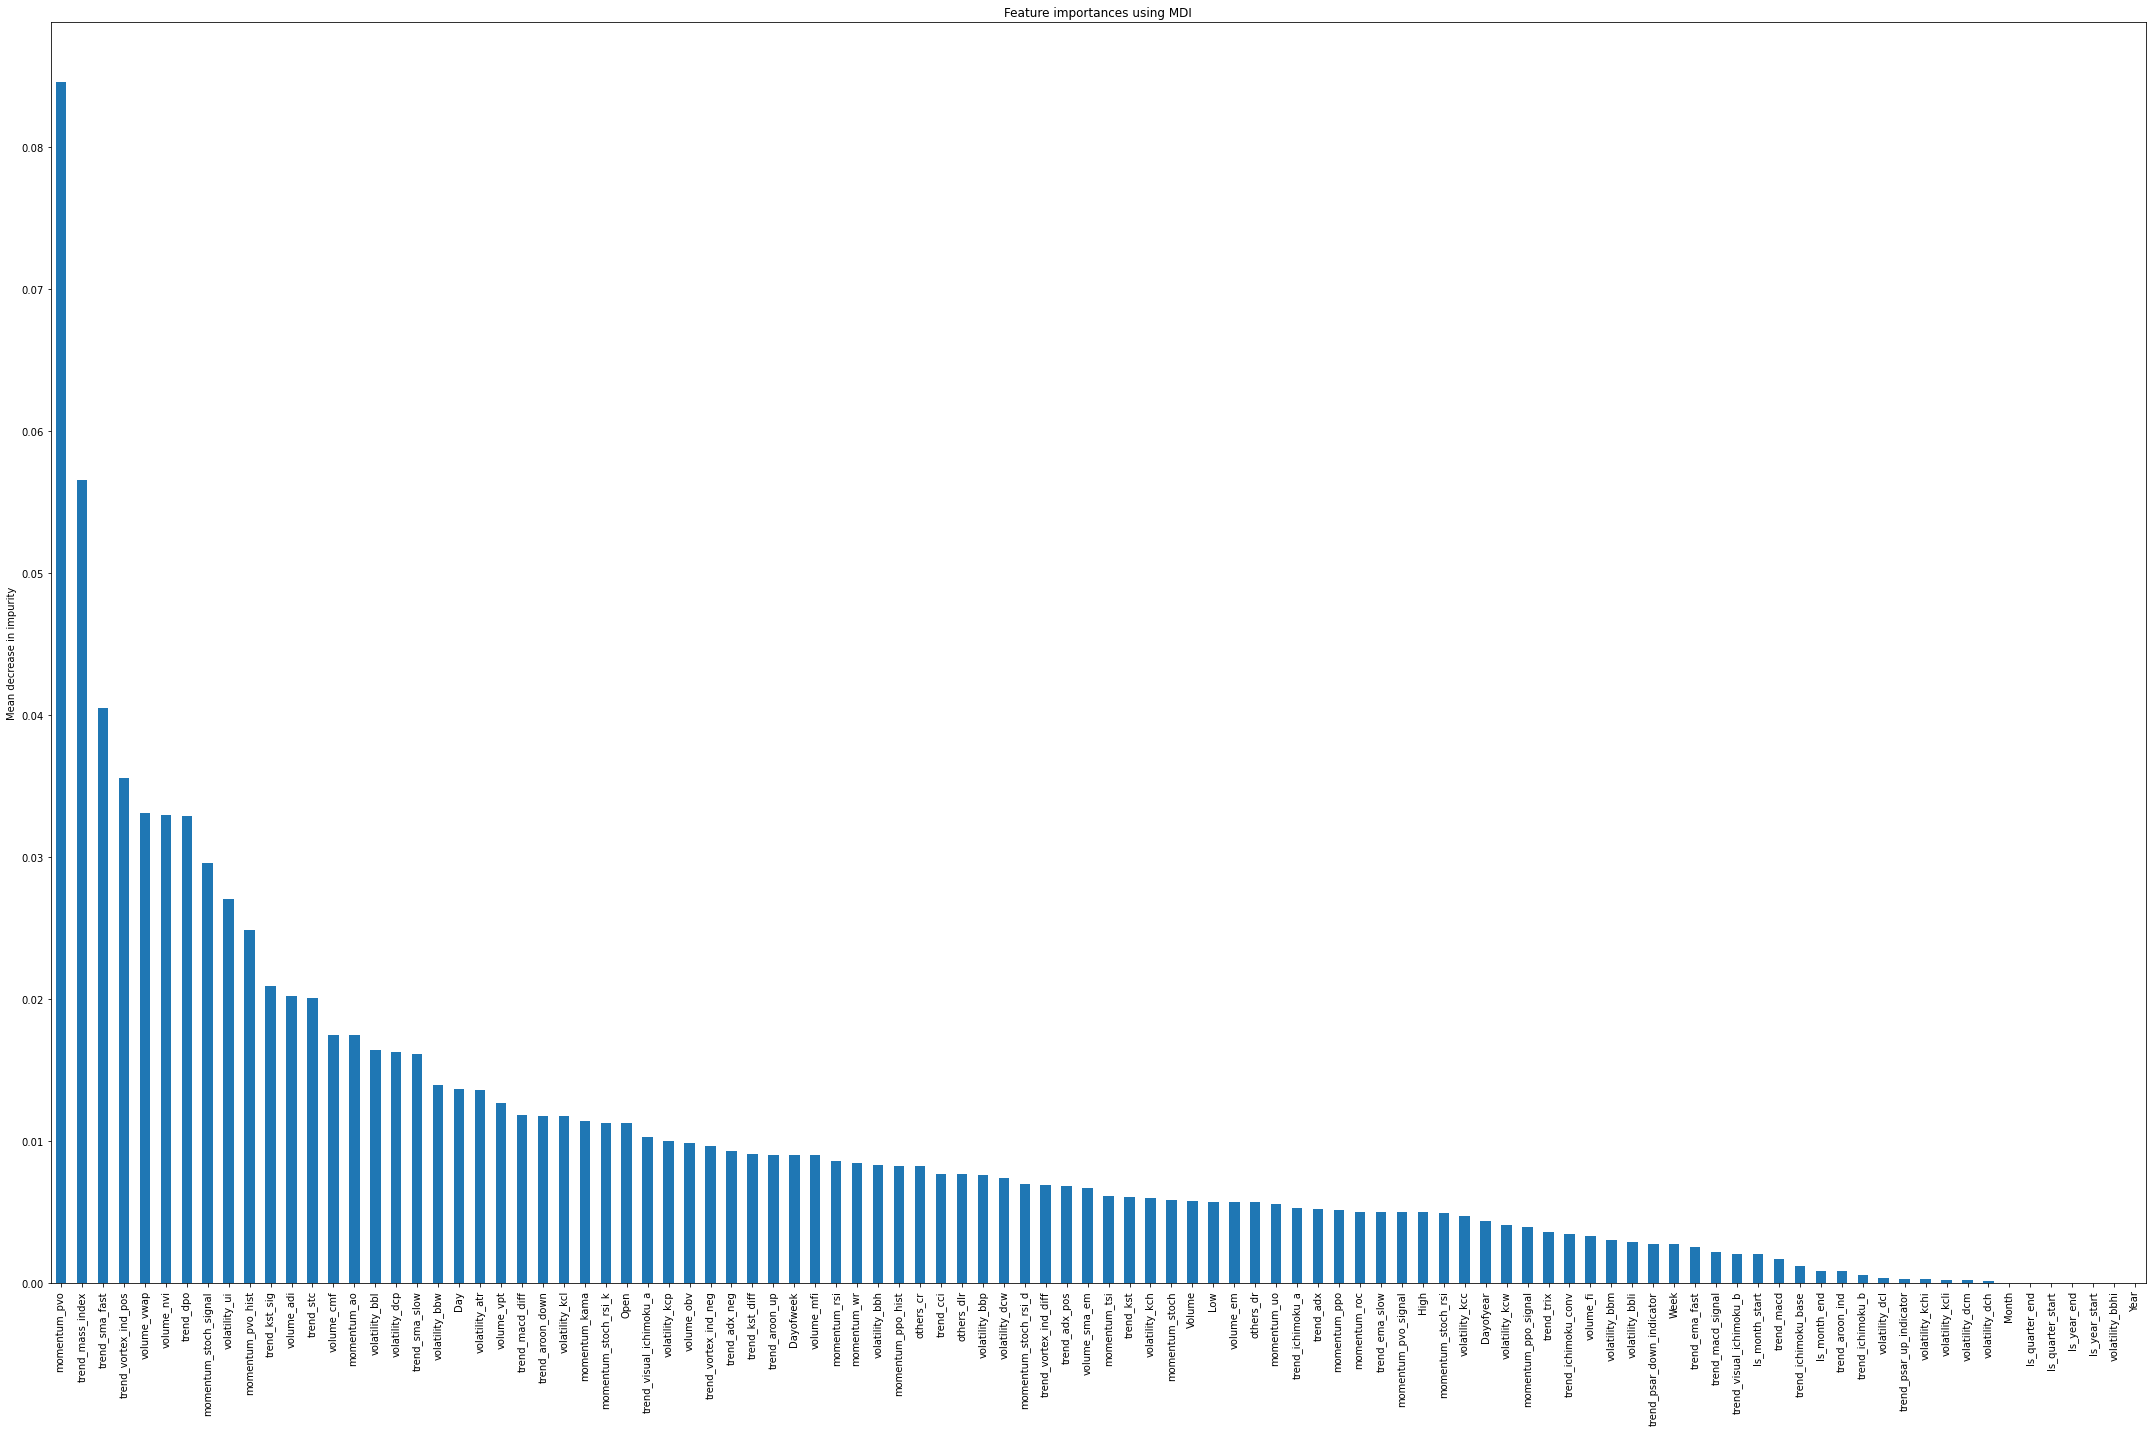

In [16]:
ave_AAPL = (rf_AAPL + ada_AAPL + gra_AAPL) / 3
imp_AAPL = feature_importance(ave_AAPL, columns_AAPL)

## Microsoft

In [17]:
# MSFT : Data with full set of technical features
X_train_MSFT, y_train_MSFT, columns_MSFT = prepare_dataset('data/MSFT_data.csv')

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


In [18]:
rf_MSFT, ada_MSFT, gra_MSFT = sklearn_cross_validation(X_train_MSFT, y_train_MSFT, 5, verbose=True, plot=False)

Mean Accuracy of Random Forests 0.48
Mean Accuracy of Adaboost 0.5
Mean Accuracy of Gradient Boosting 0.6


Top 20 Best Features : 

momentum_ppo_hist       0.102726
volume_nvi              0.051941
trend_cci               0.046427
volume_adi              0.040024
volatility_kcp          0.039808
momentum_roc            0.035931
trend_adx_neg           0.030879
trend_adx_pos           0.028290
momentum_pvo_hist       0.025961
volatility_atr          0.024305
volume_obv              0.023160
momentum_stoch_rsi      0.022521
momentum_rsi            0.019140
trend_macd_signal       0.017440
momentum_pvo            0.017350
trend_dpo               0.014540
momentum_uo             0.014229
momentum_stoch_rsi_k    0.014111
volume_fi               0.014082
trend_mass_index        0.013918
dtype: float64


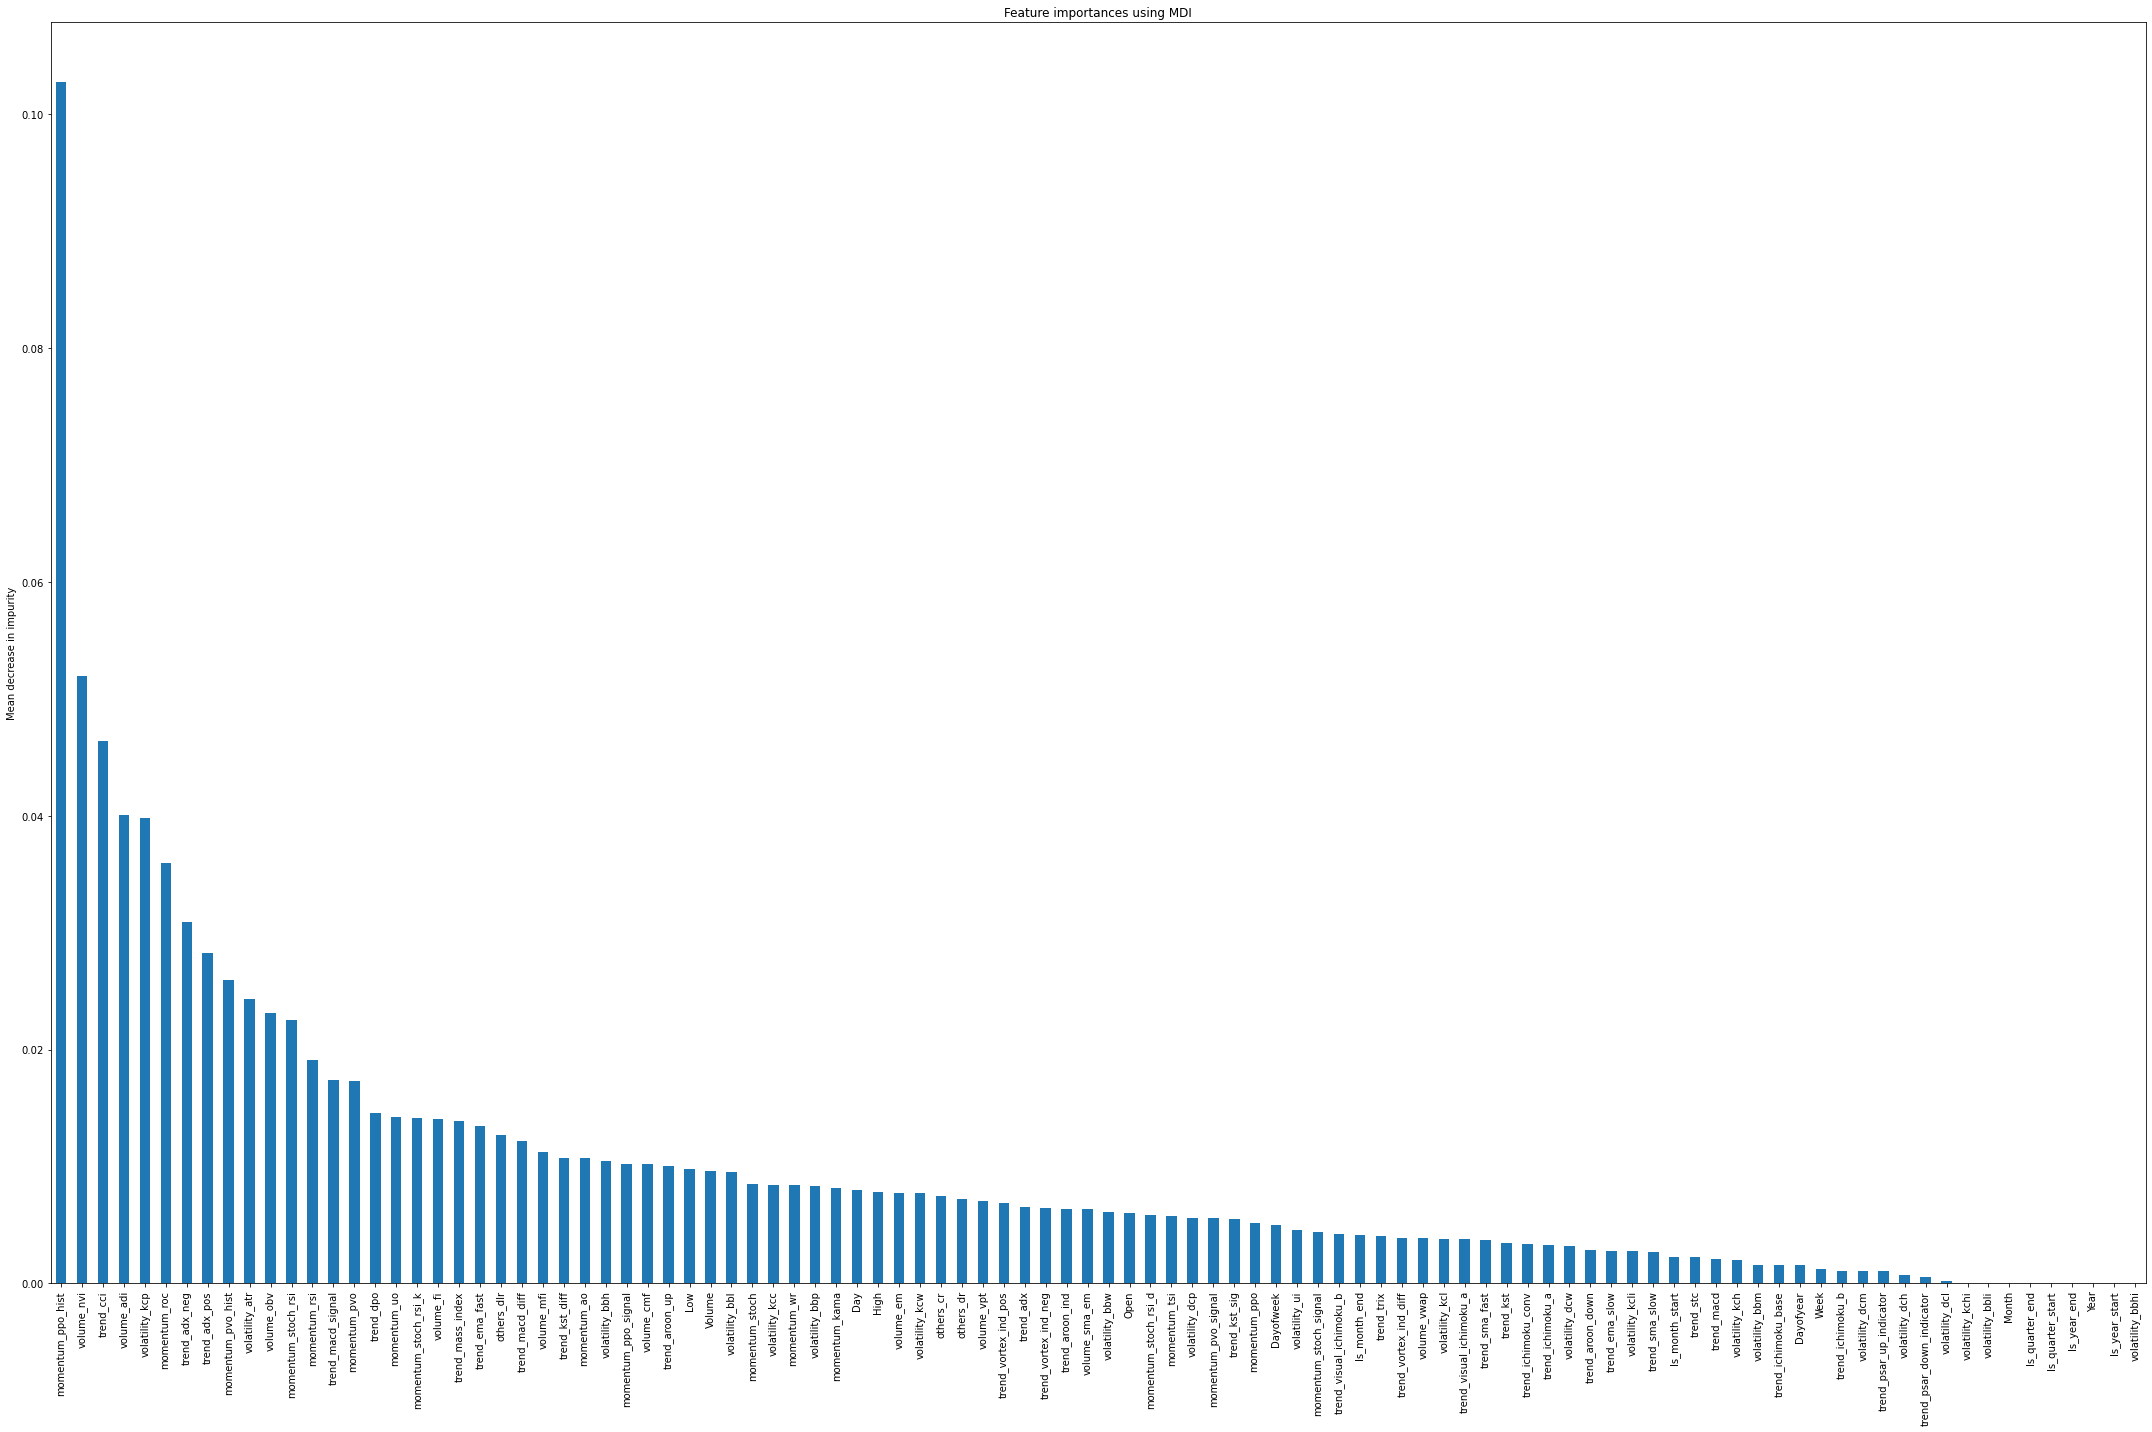

In [19]:
ave_MSFT = (rf_MSFT + ada_MSFT + gra_MSFT) / 3
imp_MSFT = feature_importance(ave_MSFT, columns_MSFT)

## NVDIA

In [20]:
# NVDA : Data with full set of technical features
X_train_NVDA, y_train_NVDA, columns_NVDA = prepare_dataset('data/NVDA_data.csv')

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


In [21]:
rf_NVDA, ada_NVDA, gra_NVDA = sklearn_cross_validation(X_train_NVDA, y_train_NVDA, 5, verbose=True, plot=False)

Mean Accuracy of Random Forests 0.52
Mean Accuracy of Adaboost 0.58
Mean Accuracy of Gradient Boosting 0.62


Top 20 Best Features : 

volatility_atr          0.181002
momentum_rsi            0.063993
Volume                  0.058769
trend_vortex_ind_neg    0.039721
trend_aroon_ind         0.031389
others_dr               0.029879
others_dlr              0.029446
volume_adi              0.024849
volatility_bbw          0.024579
momentum_kama           0.024468
trend_ema_fast          0.023745
others_cr               0.023590
volume_nvi              0.018356
momentum_pvo_hist       0.017121
Open                    0.016978
volatility_kcw          0.016029
trend_aroon_up          0.015182
momentum_stoch_rsi_k    0.013945
trend_mass_index        0.012609
momentum_roc            0.010993
dtype: float64


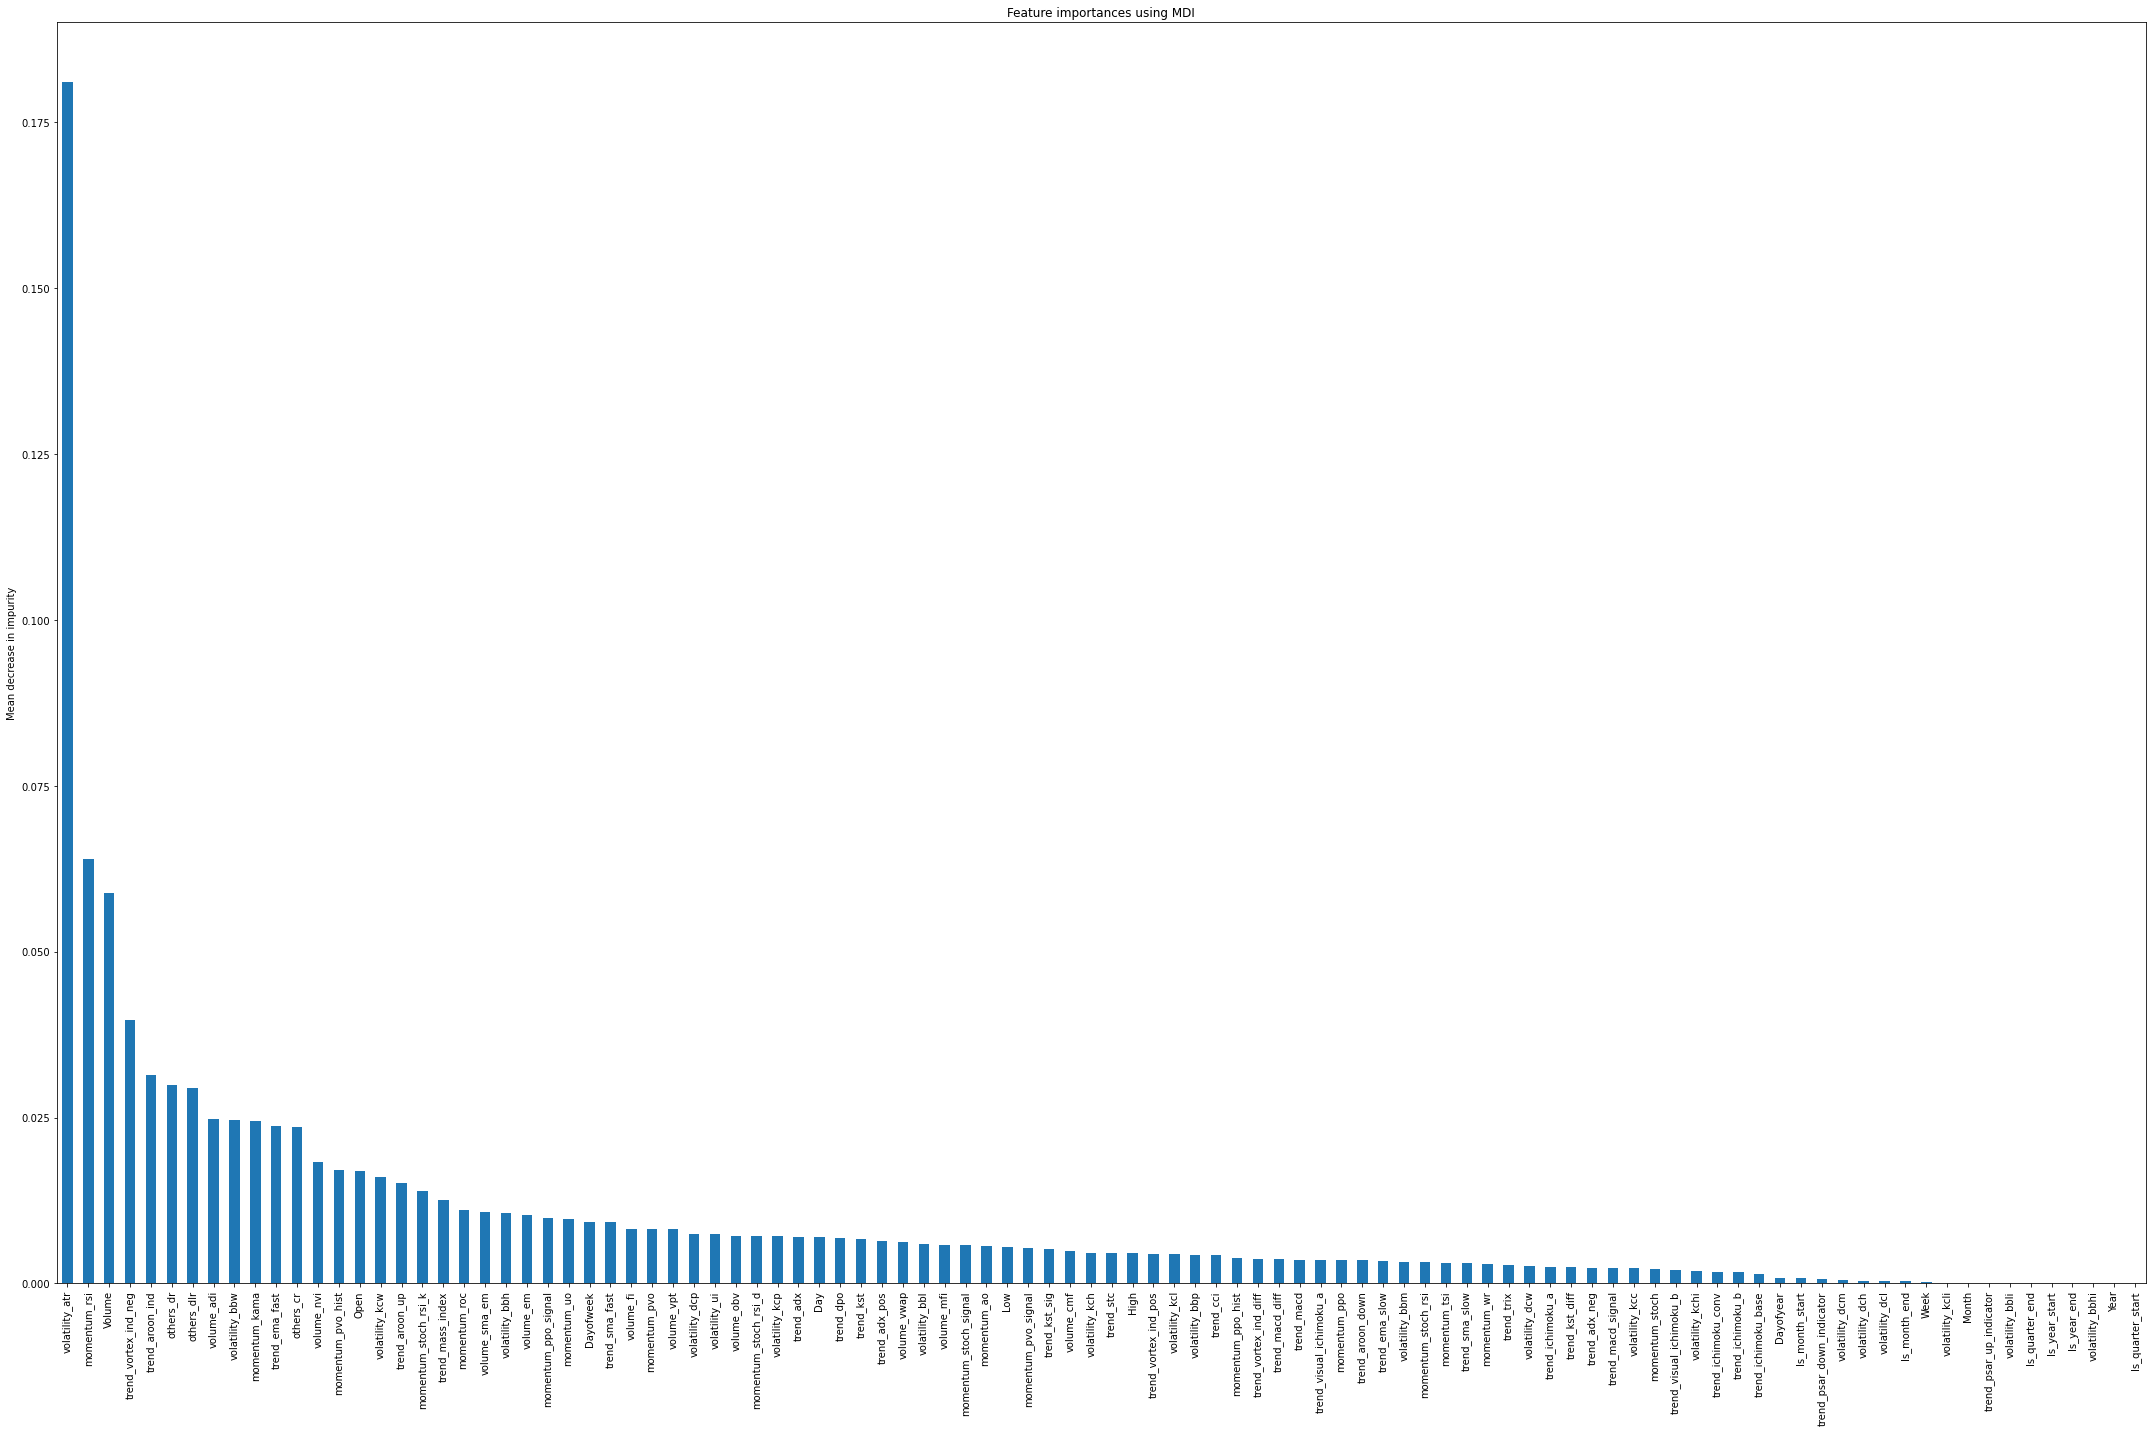

In [22]:
ave_NVDA = (rf_NVDA + ada_NVDA + gra_NVDA) / 3
imp_NVDA = feature_importance(ave_NVDA, columns_NVDA)

## Compare 3 companies feature importance

In [23]:
imp_AAPL.name = "AAPL"
imp_MSFT.name = "MSFT"
imp_NVDA.name = "NVDA"

all_companies = pd.merge(imp_AAPL, imp_MSFT, left_index=True, right_index=True)
all_companies = pd.merge(all_companies, imp_NVDA, left_index=True, right_index=True)

In [24]:
all_companies

,AAPL,MSFT,NVDA
momentum_pvo,0.084538,0.017350,0.008240
trend_mass_index,0.056574,0.013918,0.012609
trend_sma_fast,0.040505,0.003750,0.009295
trend_vortex_ind_pos,0.035584,0.006922,0.004505
volume_vwap,0.033131,0.003858,0.006262
...,...,...,...
Is_quarter_start,0.000000,0.000000,0.000000
Is_year_end,0.000000,0.000000,0.000000
Is_year_start,0.000000,0.000000,0.000000
volatility_bbhi,0.000000,0.000000,0.000000


<AxesSubplot:>

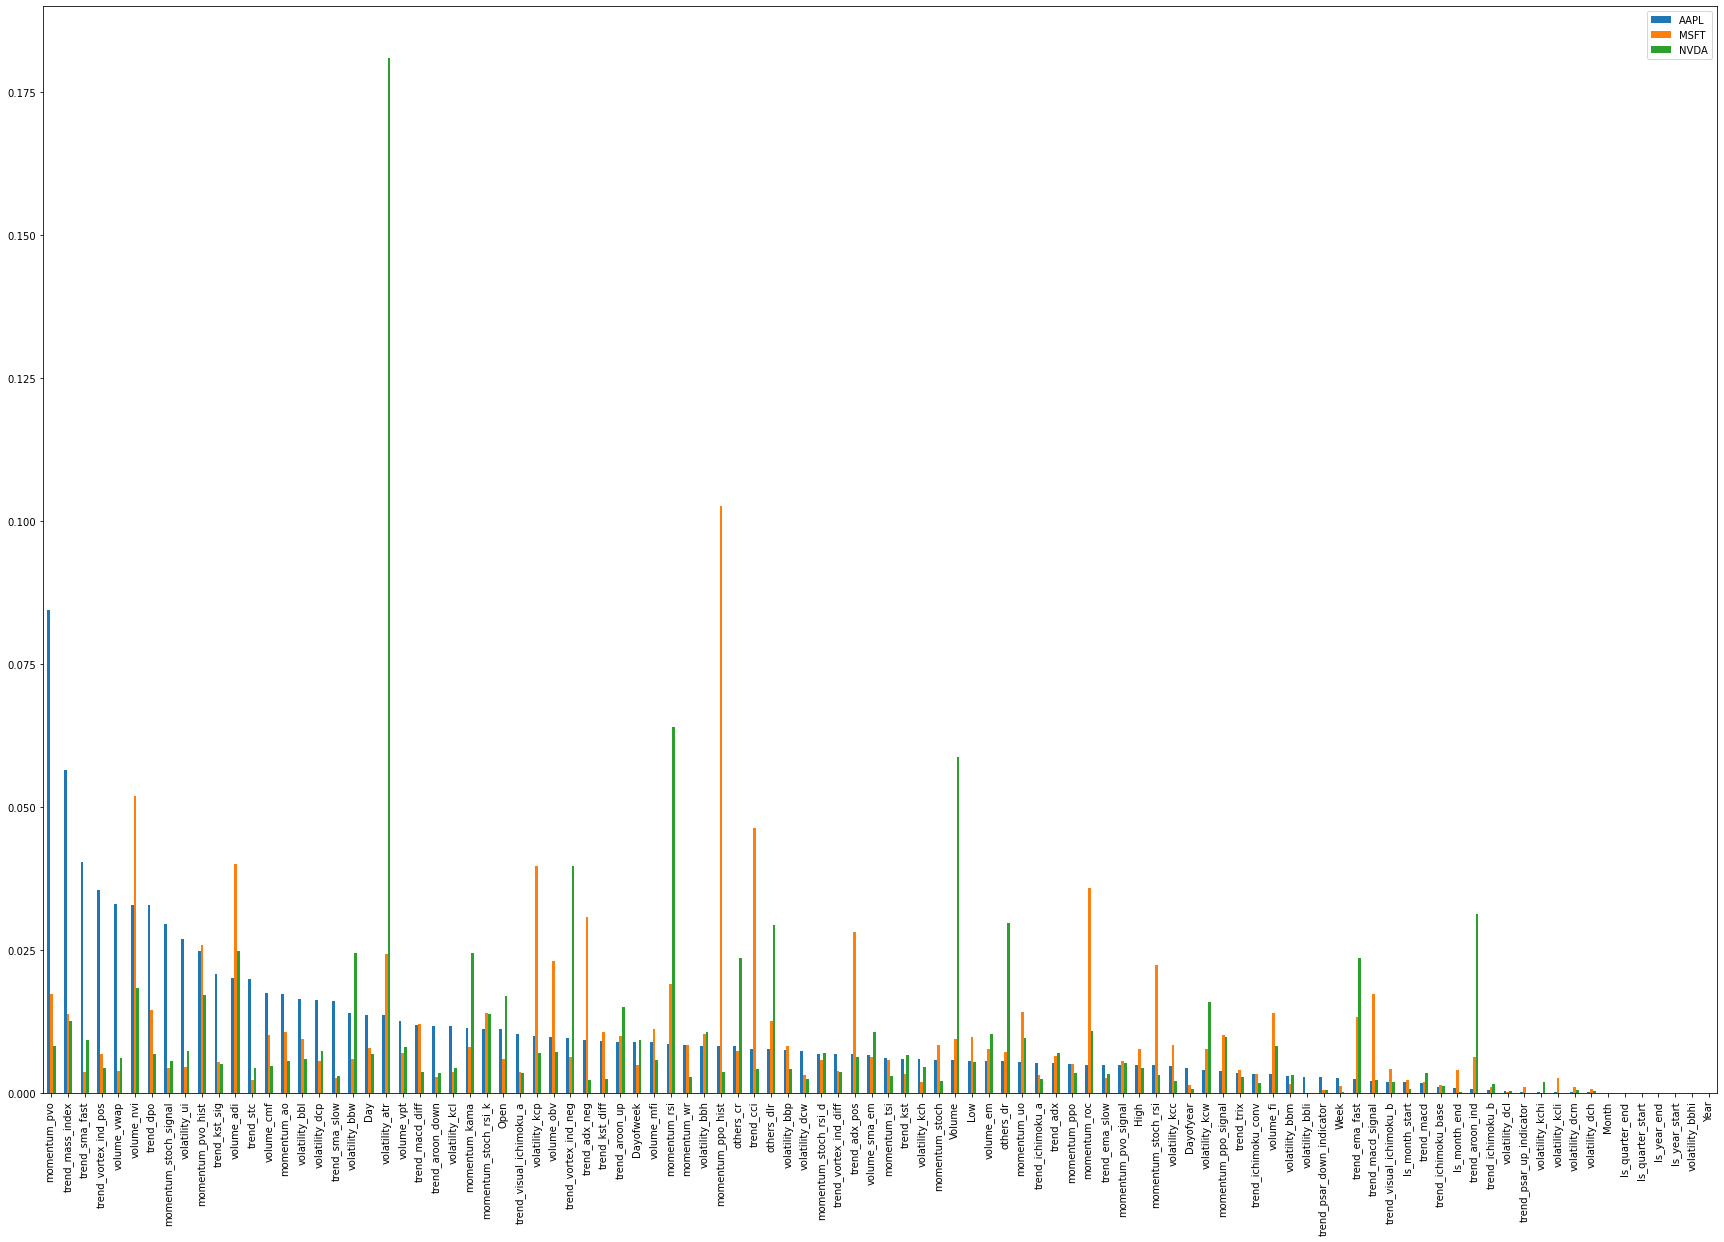

In [25]:
all_companies.plot(y=["AAPL", "MSFT", "NVDA"], kind="bar", figsize=(30,20), legend=True)

## Add Apple RoBERTa

In [26]:
# AAPL : Data with full set of technical features + sentiment score
X_train_AAPLs, y_train_AAPLs, columns_AAPLs = prepare_dataset(sentiment=True)

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


Mean Accuracy of Random Forests 0.5199999999999999
Mean Accuracy of Adaboost 0.6199999999999999
Mean Accuracy of Gradient Boosting 0.6599999999999999
Top 20 Best Features : 

momentum_pvo             0.070118
trend_mass_index         0.061561
trend_vortex_ind_pos     0.039651
trend_sma_fast           0.038044
momentum_pvo_hist        0.035682
momentum_stoch_signal    0.034432
trend_dpo                0.027371
trend_vortex_ind_neg     0.025711
volume_vwap              0.024222
trend_stc                0.023527
volatility_ui            0.023354
volume_nvi               0.023002
volume_adi               0.022893
trend_sma_slow           0.020804
trend_kst_sig            0.017815
bearish                  0.017332
bullish                  0.016903
volume_cmf               0.015798
momentum_ppo_hist        0.014854
momentum_kama            0.014373
dtype: float64


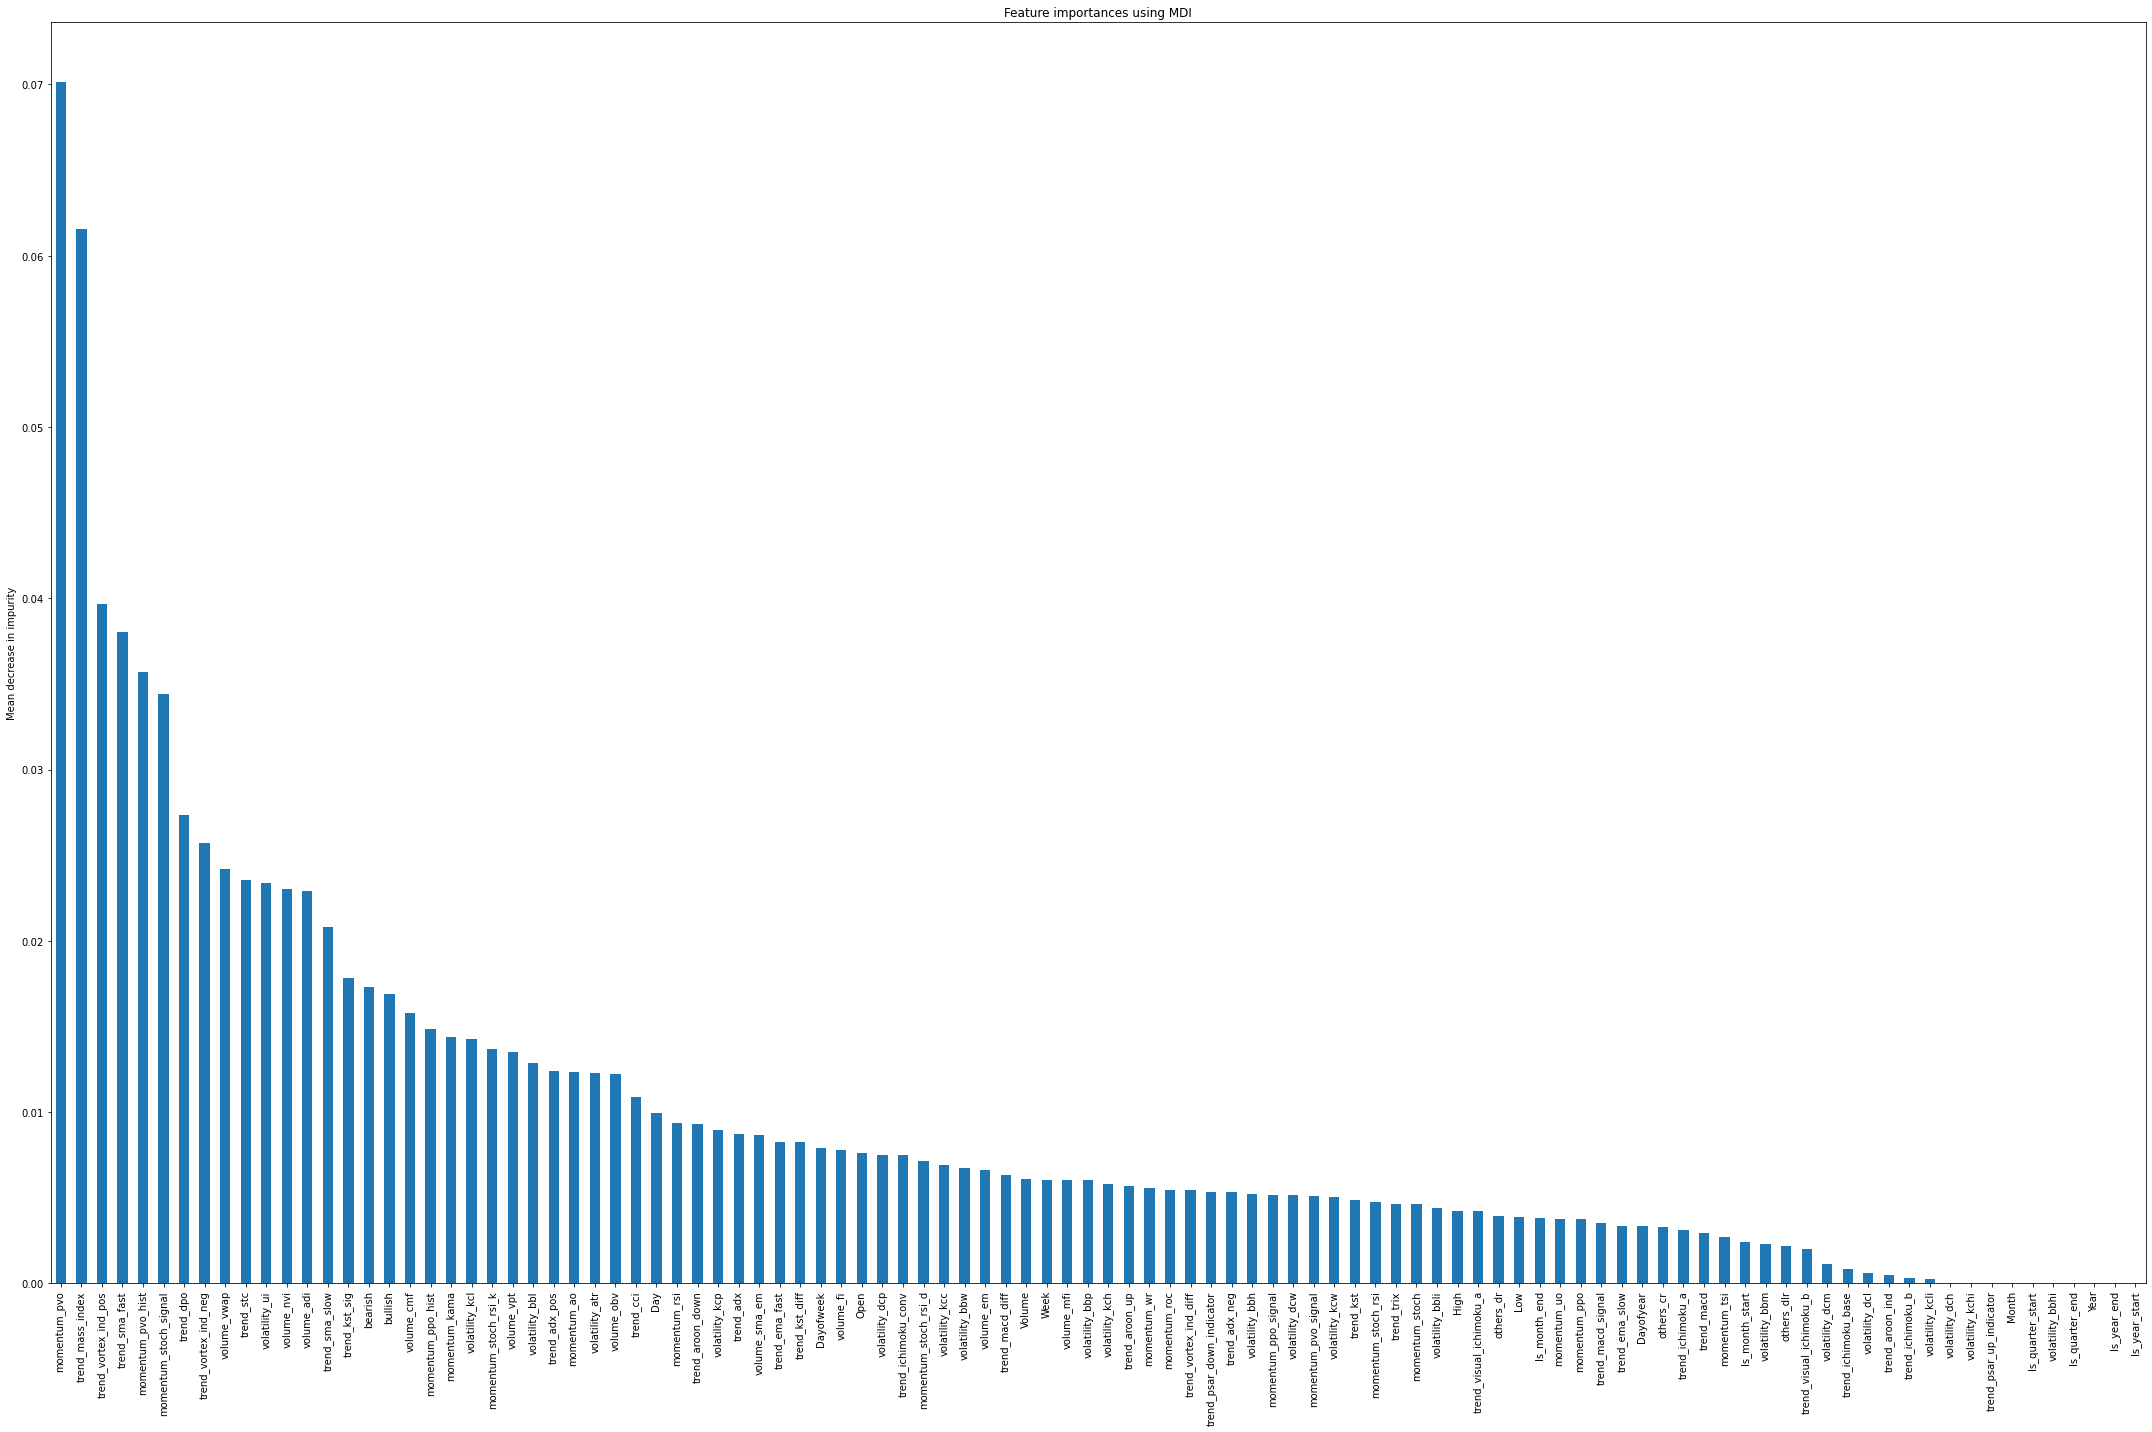

In [27]:
rf_AAPLs, ada_AAPLs, gra_AAPLs = sklearn_cross_validation(X_train_AAPLs, y_train_AAPLs, 5, verbose=True, plot=False)
ave_AAPLs = (rf_AAPLs + ada_AAPLs + gra_AAPLs) / 3
imp_AAPLs = feature_importance(ave_AAPLs, columns_AAPLs)

## Add Microsoft RoBERTa

In [28]:
# MSFT : Data with full set of technical features + sentiment score
X_train_MSFTs, y_train_MSFTs, columns_MSFTs = prepare_dataset(path = 'data/MSFT_data.csv', s_path = 'data/MSFT_byday_RoBERTa.csv', sentiment=True)

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


Mean Accuracy of Random Forests 0.45999999999999996
Mean Accuracy of Adaboost 0.52
Mean Accuracy of Gradient Boosting 0.5599999999999999
Top 20 Best Features : 

momentum_ppo_hist       0.109238
trend_cci               0.044616
volume_nvi              0.041792
volatility_kcp          0.039958
volume_adi              0.032386
momentum_roc            0.032080
trend_adx_neg           0.031819
trend_adx_pos           0.023293
bullish                 0.022417
momentum_stoch_rsi_k    0.022328
trend_macd_signal       0.021261
momentum_pvo_hist       0.021105
volatility_atr          0.019133
momentum_pvo            0.018082
bearish                 0.017657
volume_obv              0.016984
trend_mass_index        0.016410
momentum_stoch          0.015092
volume_cmf              0.015005
trend_macd_diff         0.014569
dtype: float64


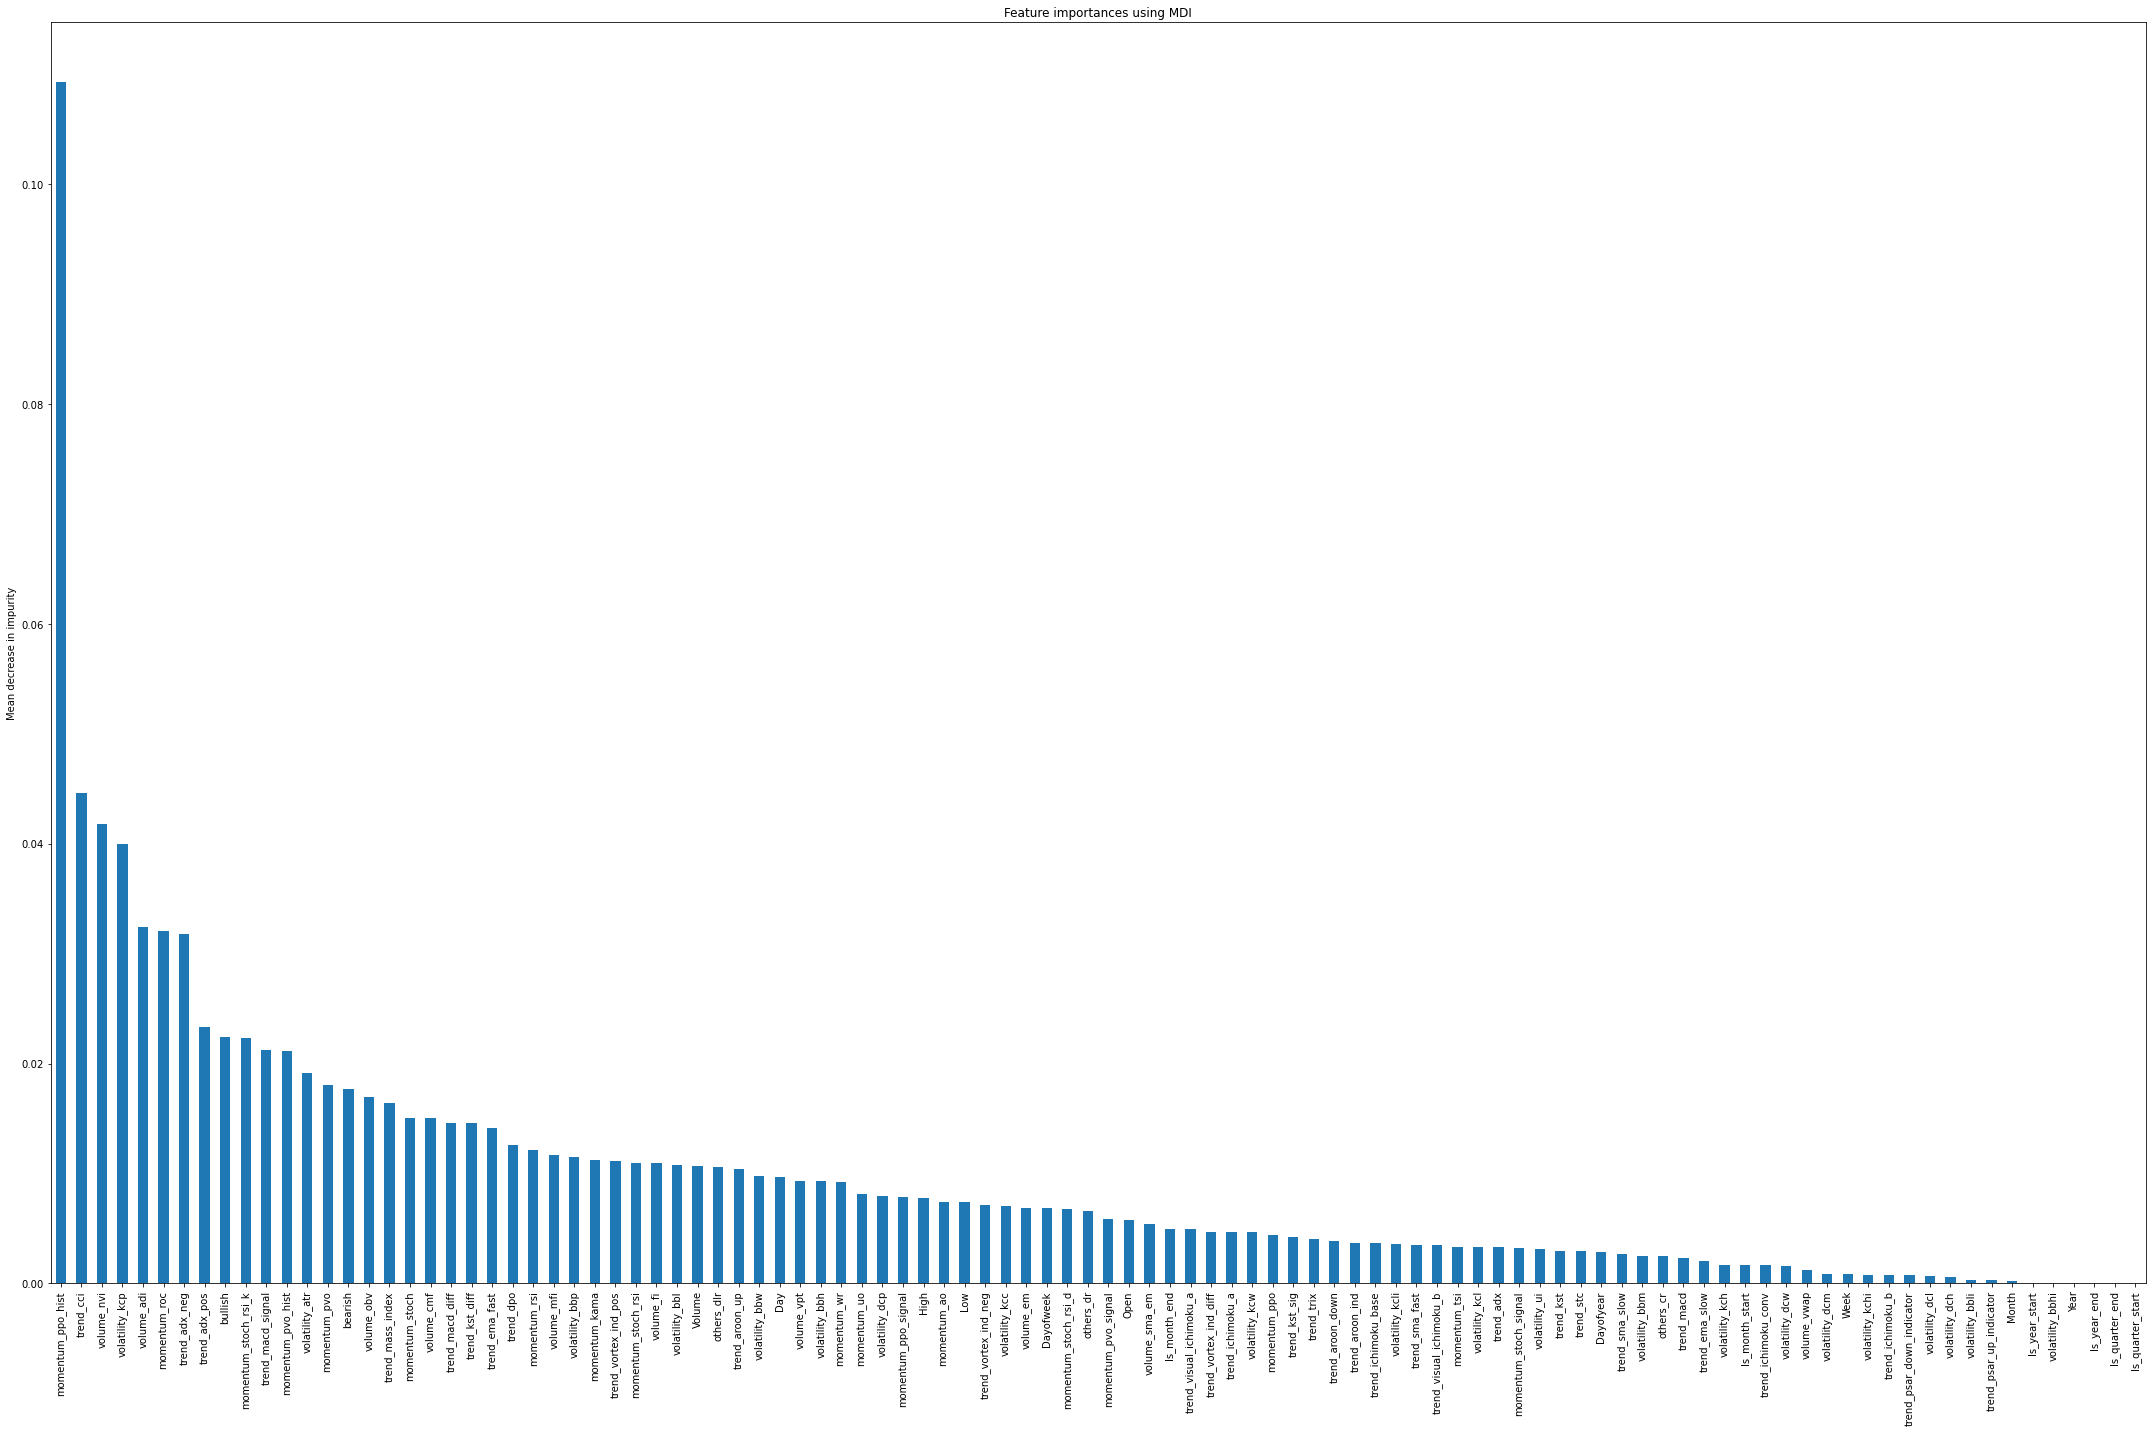

In [29]:
rf_MSFTs, ada_MSFTs, gra_MSFTs = sklearn_cross_validation(X_train_MSFTs, y_train_MSFTs, 5, verbose=True, plot=False)
ave_MSFTs = (rf_MSFTs + ada_MSFTs + gra_MSFTs) / 3
imp_MSFTs = feature_importance(ave_MSFTs, columns_MSFTs)

## Add NVDIA RoBERTa

In [30]:
# NVDA : Data with full set of technical features + sentiment score
X_train_NVDAs, y_train_NVDAs, columns_NVDAs = prepare_dataset(path = 'data/NVDA_data.csv', s_path = 'data/NVDA_byday_RoBERTa.csv', sentiment=True)

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


Mean Accuracy of Random Forests 0.52
Mean Accuracy of Adaboost 0.5599999999999999
Mean Accuracy of Gradient Boosting 0.5599999999999999
Top 20 Best Features : 

volatility_atr          0.169354
momentum_rsi            0.062869
Volume                  0.062519
trend_vortex_ind_neg    0.037821
others_cr               0.033306
trend_ema_fast          0.029880
others_dlr              0.025403
trend_aroon_ind         0.025356
momentum_kama           0.024293
others_dr               0.021279
volume_adi              0.020823
volatility_bbw          0.020788
momentum_pvo_hist       0.019090
volatility_kcw          0.016496
bearish                 0.015757
Open                    0.015757
trend_aroon_up          0.014242
volatility_bbh          0.013578
momentum_stoch_rsi_k    0.013503
bullish                 0.012979
dtype: float64


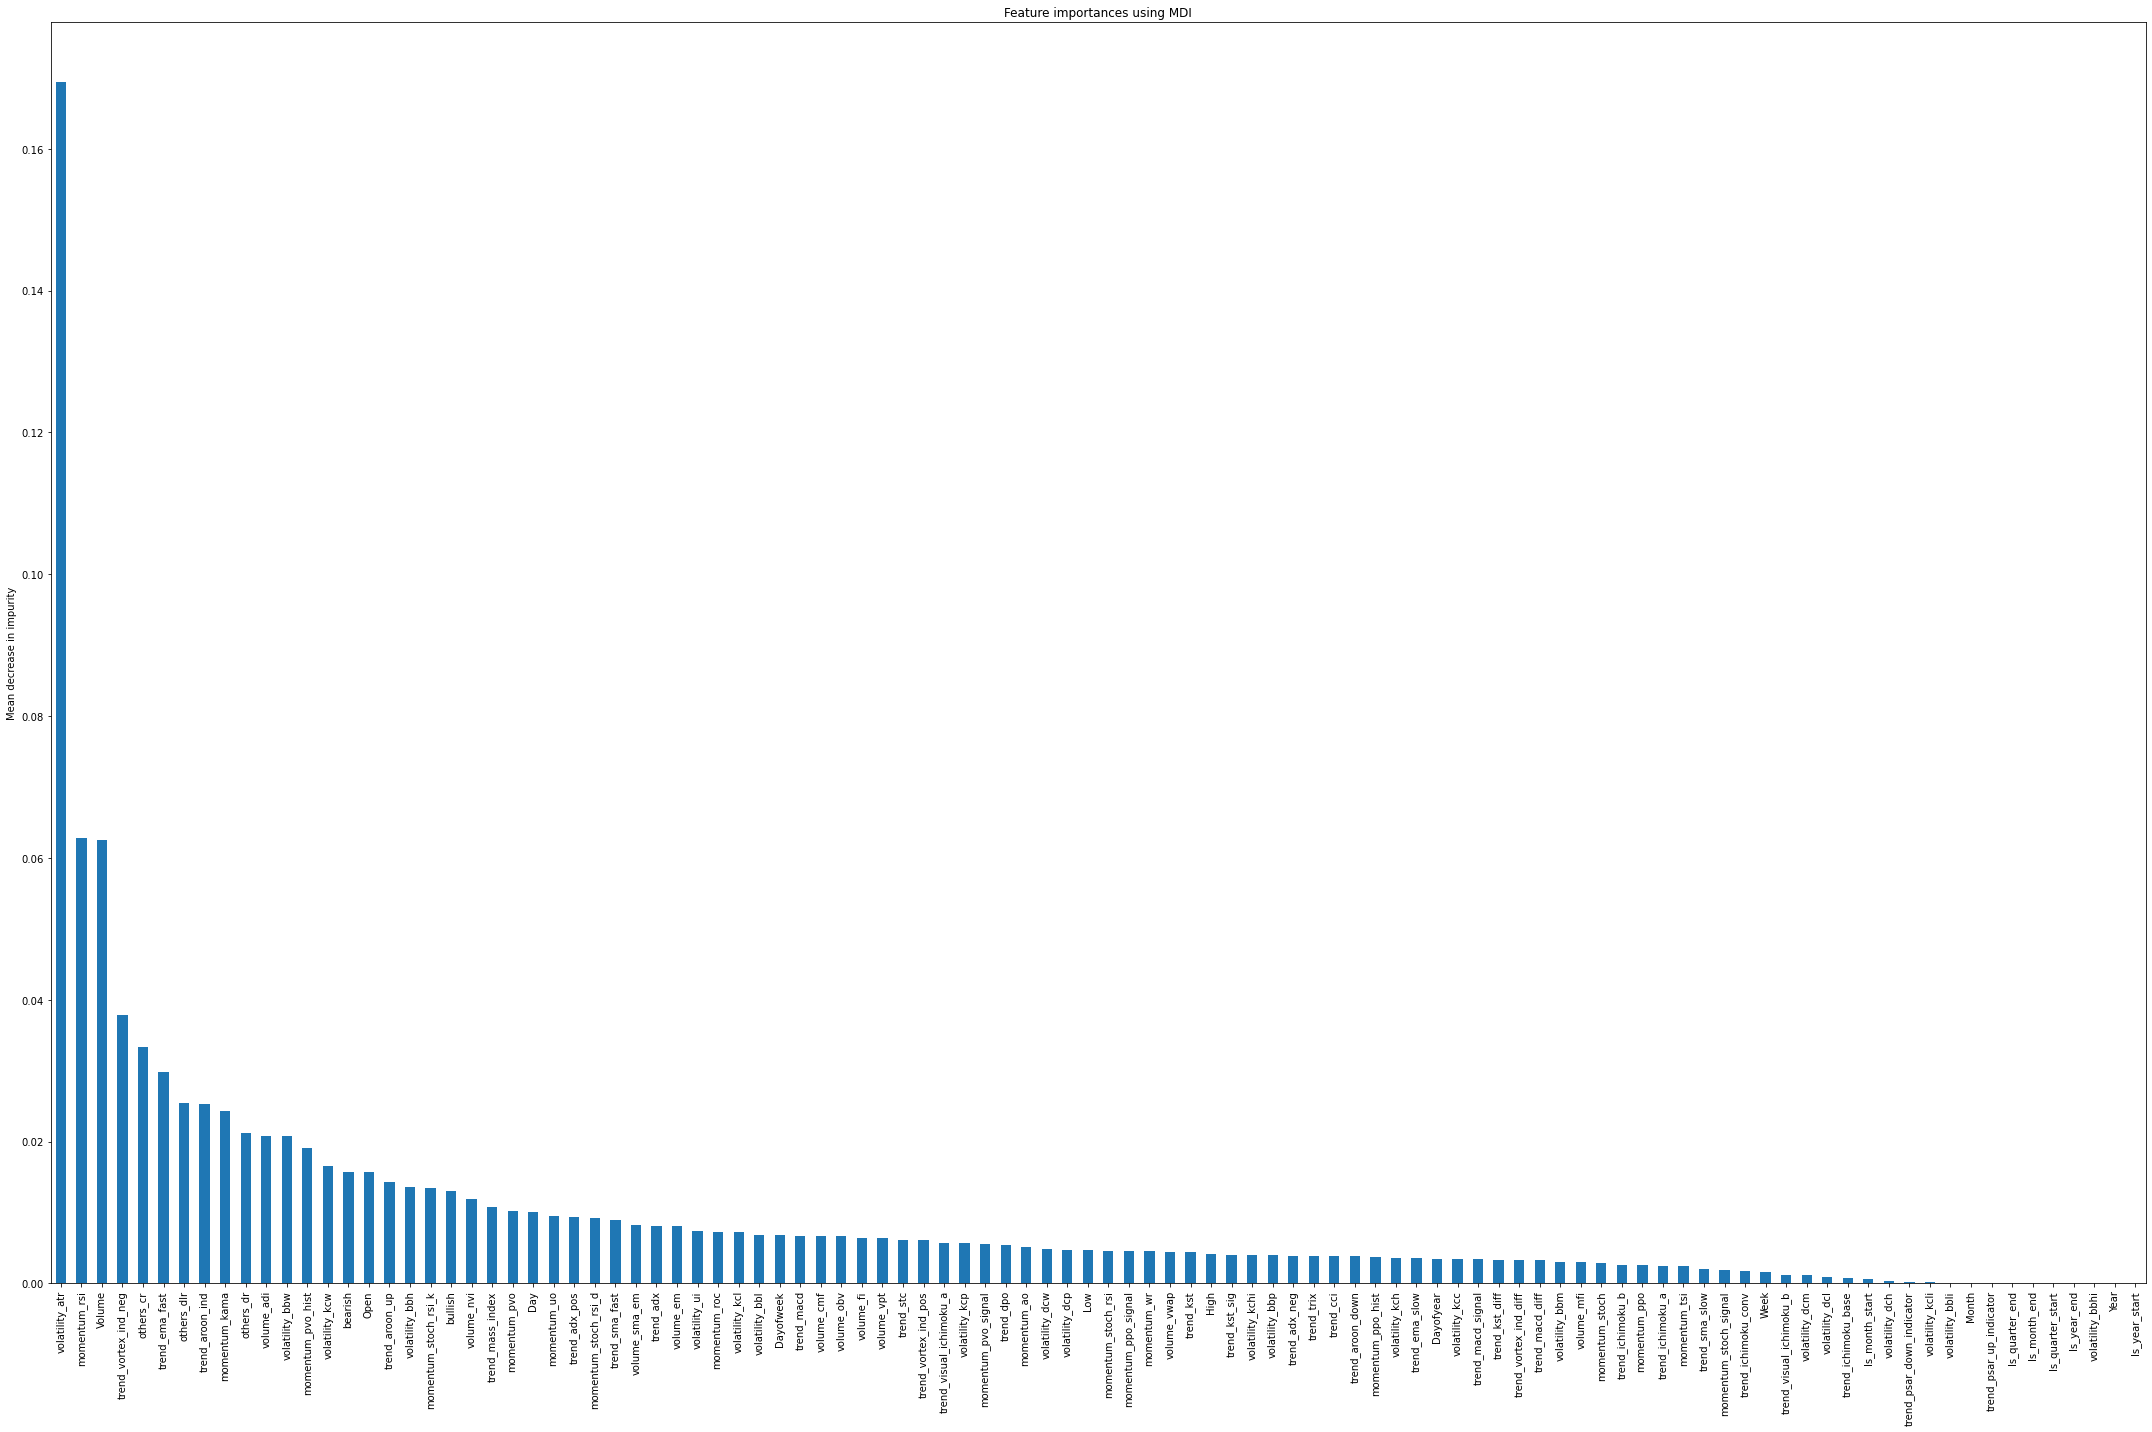

In [31]:
rf_NVDAs, ada_NVDAs, gra_NVDAs = sklearn_cross_validation(X_train_NVDAs, y_train_NVDAs, 5, verbose=True, plot=False)
ave_NVDAs = (rf_NVDAs + ada_NVDAs + gra_NVDAs) / 3
imp_NVDAs = feature_importance(ave_NVDAs, columns_NVDAs)

## Compare 3 companies feature importance with RoBERTa

In [32]:
imp_AAPLs.name = "AAPL"
imp_MSFTs.name = "MSFT"
imp_NVDAs.name = "NVDA"

all_companies_s = pd.merge(imp_AAPLs, imp_MSFTs, left_index=True, right_index=True)
all_companies_s = pd.merge(all_companies_s, imp_NVDAs, left_index=True, right_index=True)

<AxesSubplot:>

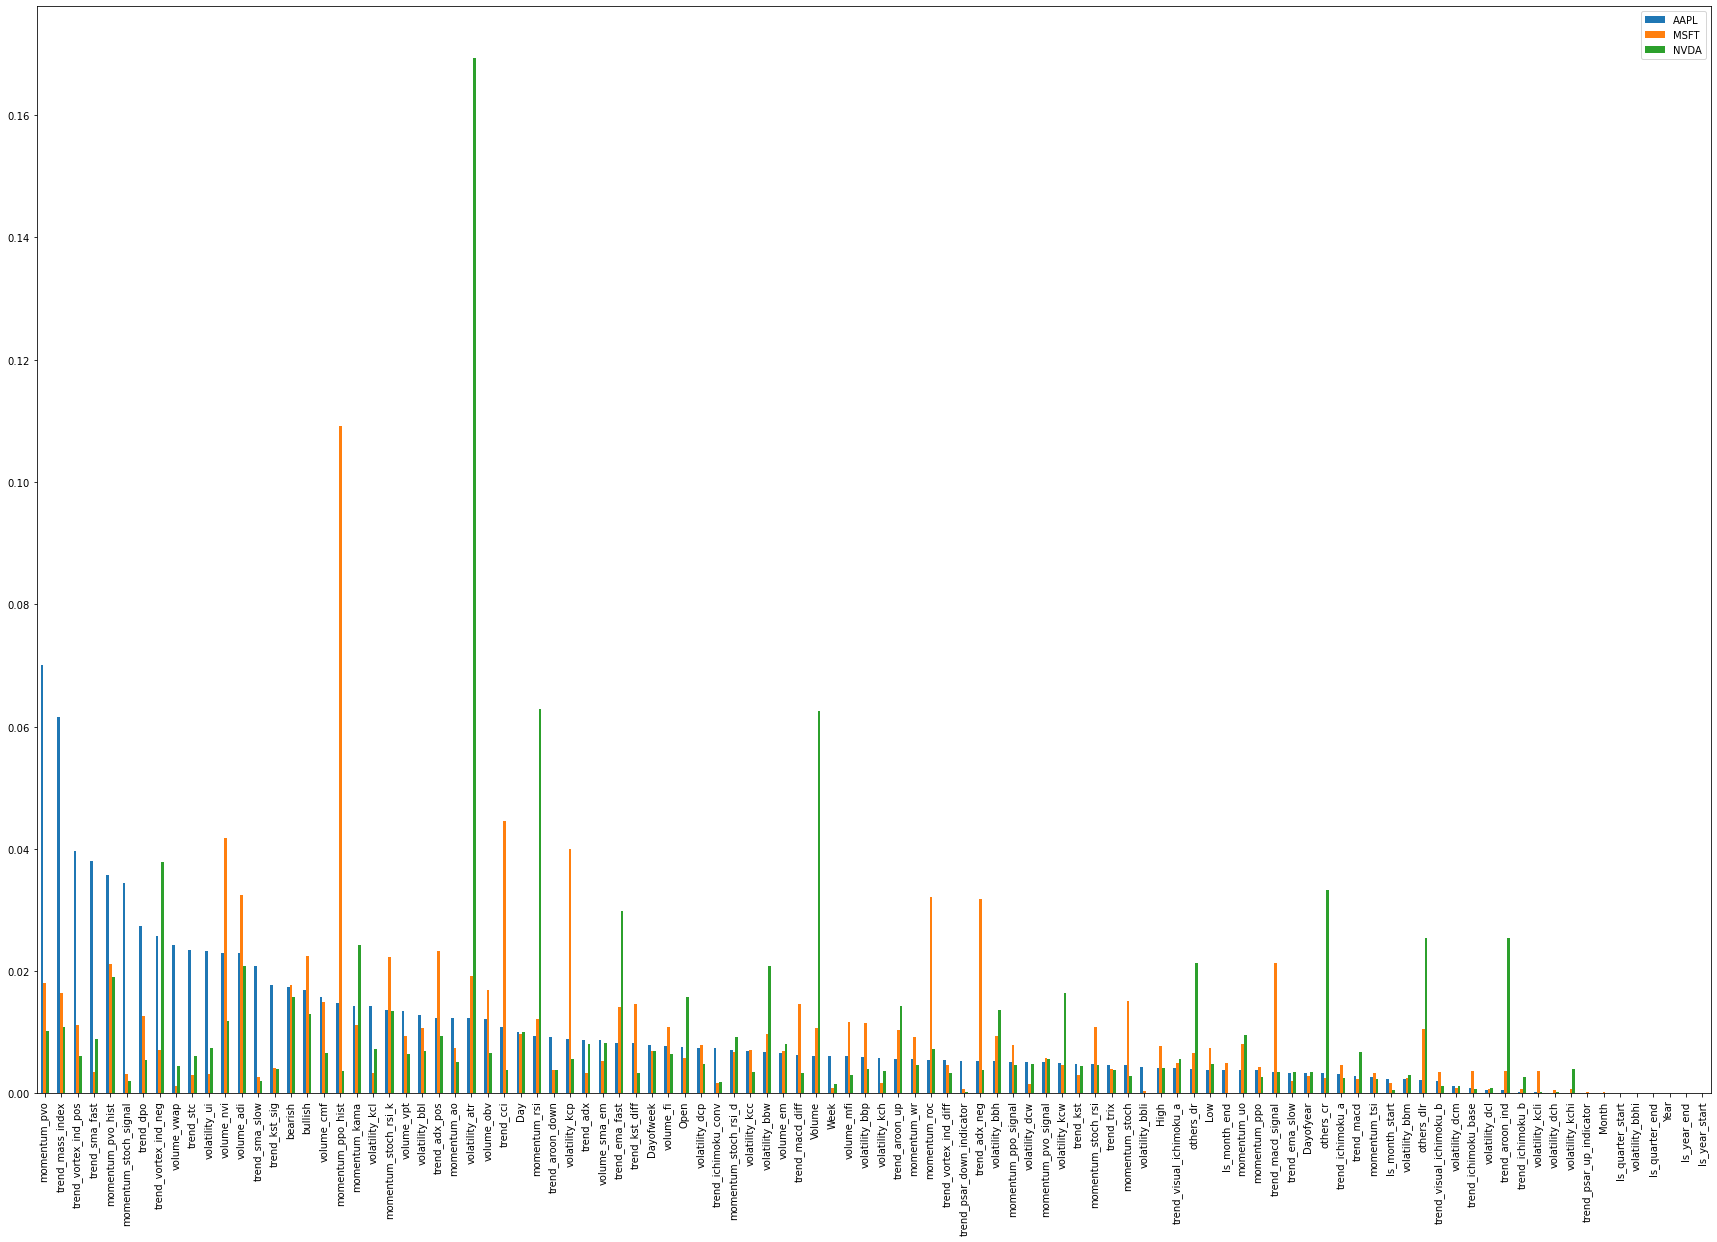

In [33]:
all_companies_s.plot(y=["AAPL", "MSFT", "NVDA"], kind="bar", figsize=(30,20), legend=True)

Although the feature importance varies among 3 companies (Apple, Microsoft, NVDIA), `bearish` and `bullish` are relatively important in common.

## Concatenate all three companies stock data and train a model

I concatenated by rows, but not sure this is the right way...

In [34]:
# Add index
X_train_AAPLss = np.insert(X_train_AAPLs, X_train_AAPLs.shape[1], values=[range(0, X_train_AAPLs.shape[0])], axis=1)
X_train_MSFTss = np.insert(X_train_MSFTs, X_train_MSFTs.shape[1], values=[range(0, X_train_MSFTs.shape[0])], axis=1)
X_train_NVDAss = np.insert(X_train_NVDAs, X_train_NVDAs.shape[1], values=[range(0, X_train_NVDAs.shape[0])], axis=1)
# Concatenate horizontally and order by index (time ascending)
X_train_alls = np.concatenate((X_train_AAPLss, X_train_MSFTss), axis=0)
X_train_alls = np.concatenate((X_train_alls, X_train_NVDAss), axis=0)
sort_order = X_train_alls[:,-1].argsort()
X_train_alls = X_train_alls[sort_order]
y_train_alls = np.concatenate((y_train_AAPLs, y_train_MSFTs), axis=0)
y_train_alls = np.concatenate((y_train_alls, y_train_NVDAs), axis=0)
y_train_alls = y_train_alls[sort_order]
X_train_alls = np.delete(X_train_alls, -1, axis=1)
# Make a dummy variable : AAPL=0, MSFT=1, NVDA=2
dummy1 = np.zeros(len(X_train_AAPLss))
dummy2 = np.ones(len(X_train_MSFTss))
dummy3 = np.full((len(X_train_NVDAss),), 2)
dummy = np.concatenate((dummy1, dummy2), axis=0)
dummy = np.concatenate((dummy, dummy3), axis=0)
dummy = dummy.reshape(-1,1)
dummy = dummy[sort_order]
X_train_alls = np.concatenate((X_train_alls, dummy), axis=1)
# Add column name
columns_alls = columns_AAPLs
columns_alls = columns_alls.to_list()
columns_alls.append("dummy")

Mean Accuracy of Random Forests 0.4875
Mean Accuracy of Adaboost 0.48125
Mean Accuracy of Gradient Boosting 0.54375
Top 20 Best Features : 

volatility_kcp          0.066477
momentum_pvo            0.038275
Day                     0.036546
trend_mass_index        0.034281
momentum_ppo_hist       0.032557
trend_vortex_ind_neg    0.028562
volume_cmf              0.021973
trend_adx               0.021689
momentum_stoch_rsi_k    0.021593
others_dlr              0.021334
volume_vpt              0.019683
Volume                  0.018650
volume_obv              0.018587
volatility_dcp          0.017911
others_dr               0.017843
trend_cci               0.017801
trend_macd_diff         0.017433
bearish                 0.017089
bullish                 0.016371
Dayofweek               0.015386
dtype: float64


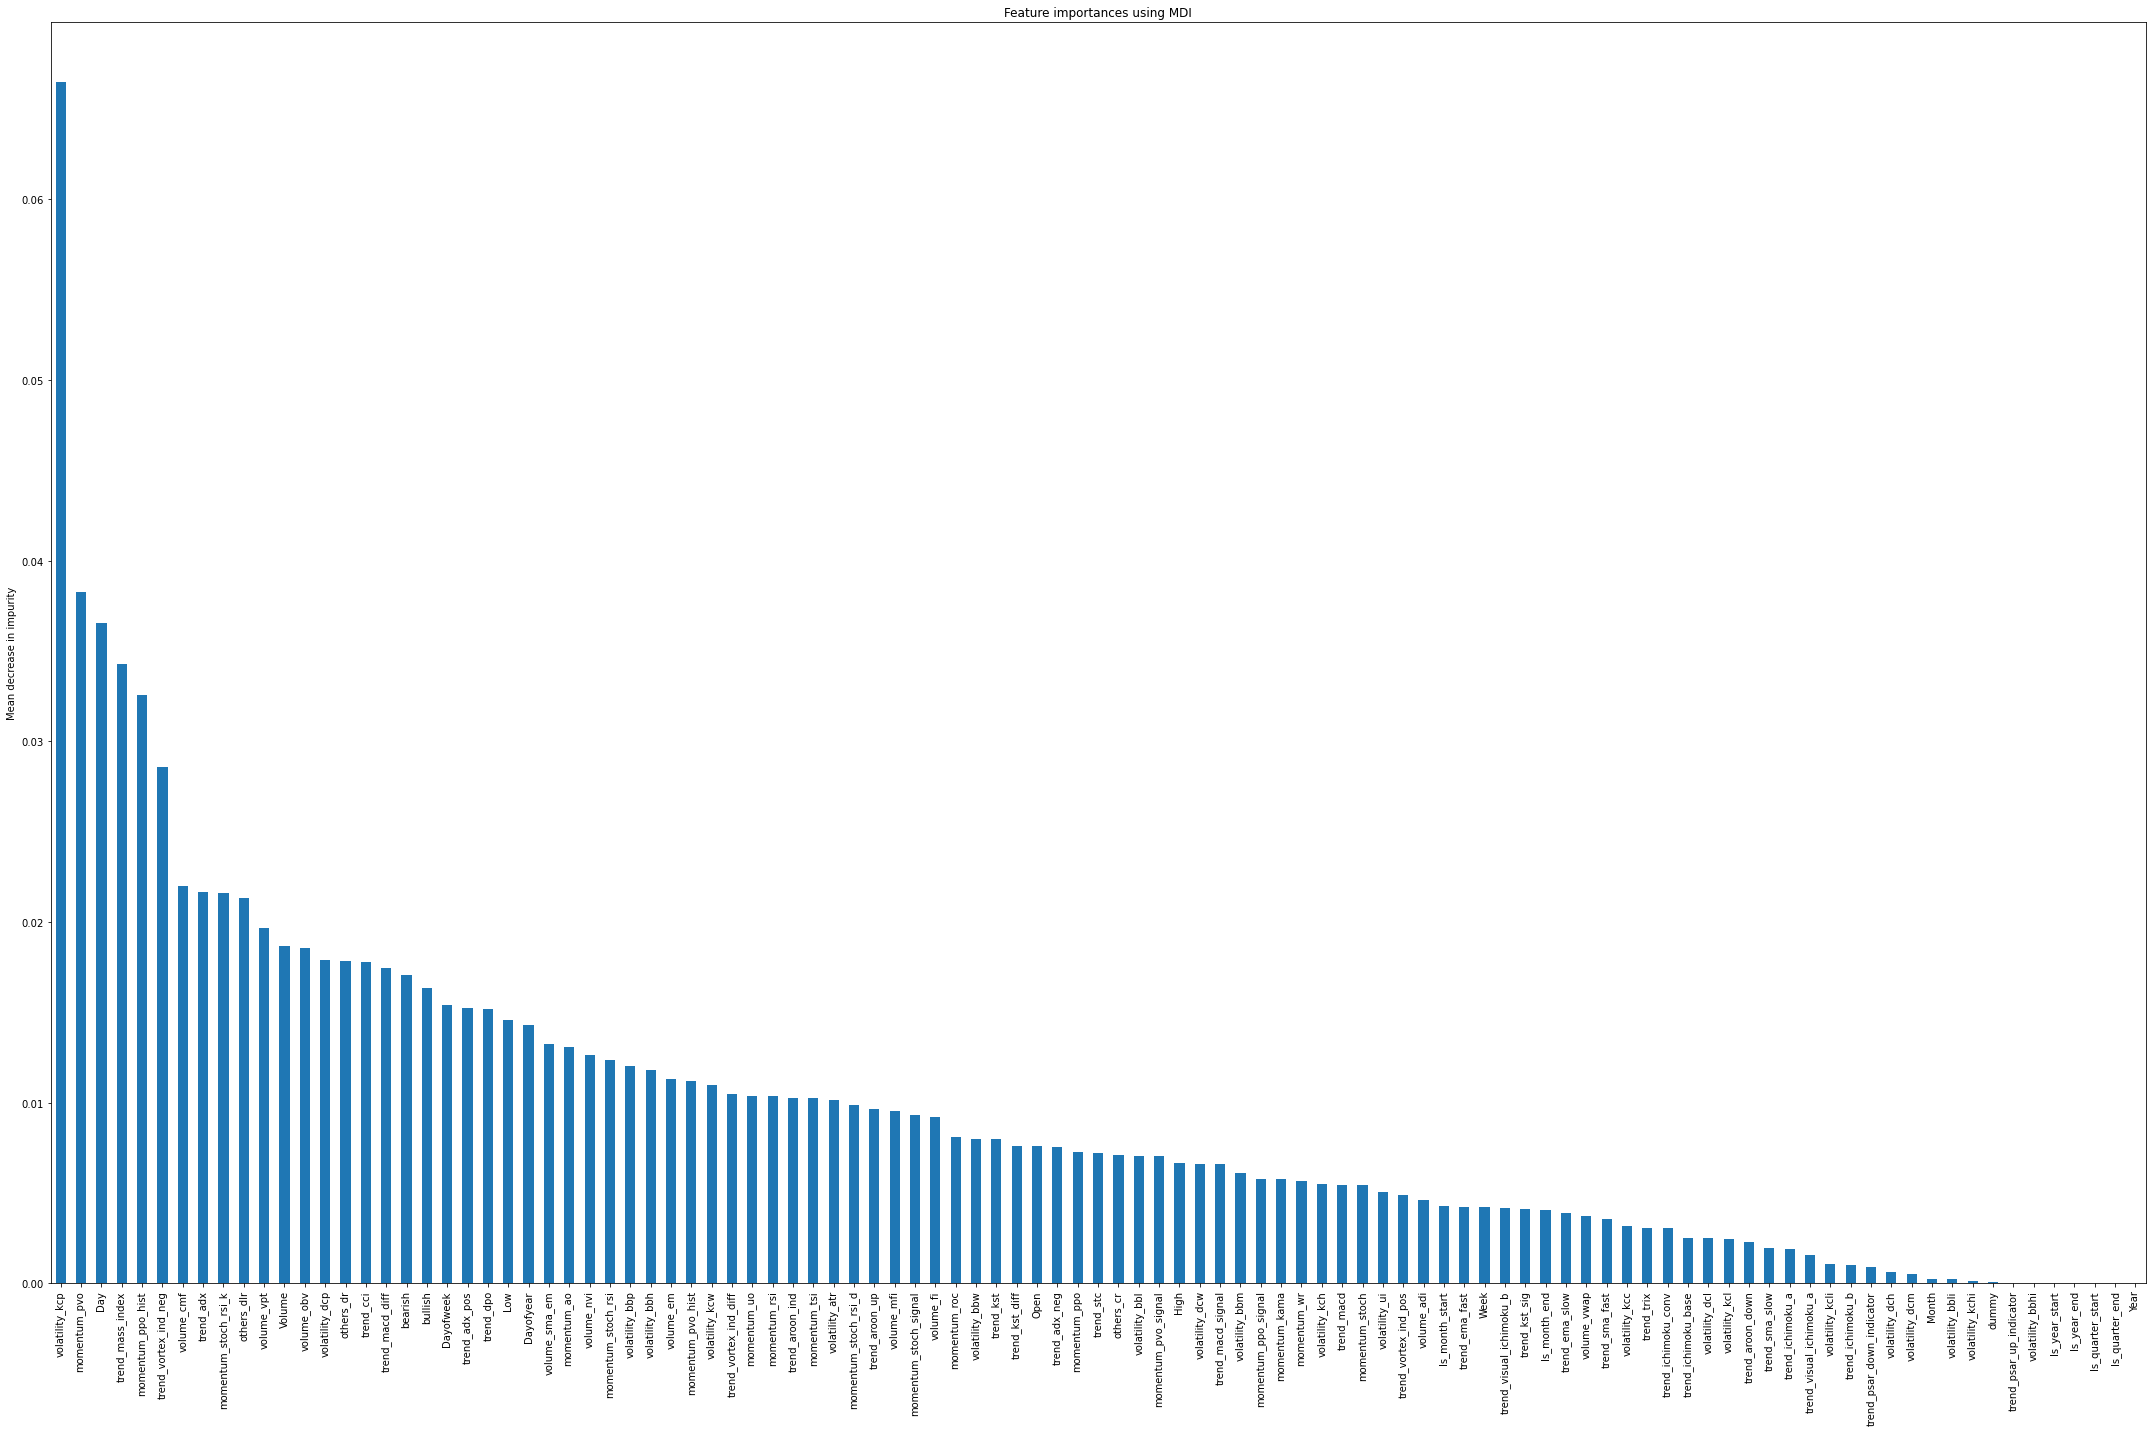

In [35]:
rf_alls, ada_alls, gra_alls = sklearn_cross_validation(X_train_alls, y_train_alls, 5, verbose=True, plot=False)
ave_alls = (rf_alls + ada_alls + gra_alls) / 3
imp_alls = feature_importance(ave_alls, columns_alls)